In [1]:
import requests            # for web crawling
from io import StringIO    # read and write strings as files
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone, date   # get current time
from dateutil.relativedelta import relativedelta  # offset days or months
import matplotlib.pyplot as plt   # to plot
import csv     # to export our dataframes as CSV files
import pytz    # get datetime in certain timezone (World Timezone Definitions for Python)

In [2]:
weekend = set([5, 6])                   # define weekends
offset = 1
def date_generator(offset, now):        # get dates and convert a datetime object to string
    now = now - timedelta(days=offset)
    while now.weekday() in weekend:
        now = now - timedelta(days=1)   # skip weekends
    date_str = datetime.strftime(now,'%Y-%m-%d')
    date_str = date_str.replace("-","") # turn dates to strings
    print("date_str=",date_str)
    return now, date_str
# date_generator(1,now)


<font color=#0055ff size=6>Stock Screening (Step1)</font><br>
<font color=#002200 size=4>Screen out most stocks, only pick those both domestic institution investors (DIIs) and foreign institutional investors (FIIs) have bought within the last 5 days from today.</font>
<br>
<font color=#555555 size=4>(The information is available in public view for every investor on the daily basis)</font>
<br>

In [3]:
def replace_comma(value):               # remove commas in our data
    temp = ""
    value = str(value)
    if ',' in value:
        temp = value[0:len(value)-3].replace(',', '')
    else:
        temp = value
    return temp

def dataframe_generator(date_str):
    # crawl data from TWSE (Taiwan Stock Exchange Corporation)
    r2 = requests.get('http://www.tse.com.tw/fund/T86?response=csv&date='+date_str+'&selectType=ALLBUT0999') 
    df2 = pd.read_csv(StringIO(r2.text), header=1).dropna(how='all', axis=1).dropna(how='any')
    df2 = df2[['證券代號','證券名稱','外陸資買賣超股數(不含外資自營商)', '投信買賣超股數']]
    # units that DII & FII have bought in a given date 
    col = ["投信買賣超股數","外陸資買賣超股數(不含外資自營商)"]
    # remove commas and convert strings to integers
    df2[col] = df2[col].applymap(replace_comma).astype(int)
    # only keep those both DII and FII has bought within recent 5 days
    df2 = df2.loc[(df2["外陸資買賣超股數(不含外資自營商)"] > 0) | (df2["投信買賣超股數"] > 0)] 
    df2['外資投信同買天數'] = 0
    df2.loc[(df2["外陸資買賣超股數(不含外資自營商)"] > 0) & (df2["投信買賣超股數"] > 0), '外資投信同買天數'] = 1
#    df2 = df2.loc[df2['證券代號'].str.len() < 5]            # uncomment this line if you want to delete ETF
    return df2
#dataframe_generator(date_generator(1,now)[1])

In [4]:
df_list = []
now = datetime.now(pytz.timezone('Asia/Taipei'))  # get current local time in Taiwan (need to import pytz first)
while len(df_list) < 5:                           # append dataframes to df_list within recent five days
    now, date_str = date_generator(offset, now)
    df_list.append(dataframe_generator(date_str))
# concatenate dataframes within the last 5 days from today
new_df = pd.concat(df_list, axis=0)                 
# delete the stocks that shows Foreign Investment Institution and Domestic Institution haven't both both bought
new_df = new_df.loc[new_df["外資投信同買天數"] > 0]  

date_str= 20190121
date_str= 20190118
date_str= 20190117
date_str= 20190116
date_str= 20190115


In [18]:
grouped = new_df.groupby(['證券代號','證券名稱'], as_index=False).agg({"外陸資買賣超股數(不含外資自營商)":"sum","投信買賣超股數":"sum","外資投信同買天數":"sum"})
# sort the picked stocks in an ascending order according to the number of days both FII and DII have bought 
result = grouped.sort_values("外資投信同買天數", ascending = False) 
result['證券代號'] = result['證券代號'].str.replace('=','').str.replace('"','')
display(result)
c = np.array([result['證券代號'],result['證券名稱']])     # save stock ID's in an array
c[0]

證券代號            證券名稱  外陸資買賣超股數(不含外資自營商)  投信買賣超股數  外資投信同買天數
122    8482  商億-KY                         555      183         4
16     2049  上銀                           4153      396         4
119    8341  日友                            973      446         4
25     2327  國巨                           1984      905         4
105    6192  巨路                             65      135         4
49     2474  可成                           3241      400         4
130    0050    元大台灣50                    11074      106         4
43     2439  美律                           4984      571         4
95     4927  泰鼎-KY                        7328     1935         4
22     2308   台達電                         9748     1216         3
45     2454   聯發科                         6379       48         3
20     2239  英利-KY                         105      121         3
116    6670    復盛應用                        124        7         3
51     2492   華新科                         2773      434         3
17     2104    國際中橡                      12824     3397         3
70     3034  聯詠                           2842     1137         3
124    9904  寶成                           5157     2488         3
102    5876    上海商銀                       8352     2884         3
10     1590   亞德客-KY                       889      278         3
99     5288  豐祥-KY                         879      312         3
34     2379  瑞昱                           3231      128         3
35     2382  廣達                           6542     5814         3
5      1515  力山                            608      104         3
4      1477  聚陽                           1918      743         3
36     2383   台光電                         2877     1300         3
107    6213  聯茂                           1752     1983         2
109    6269  台郡                            401      174         2
108    6239  力成                           2936     1006         2
81     3596  智易                           4580      581         2
50     2481  強茂                           1498      156         2
..      ...             ...                ...      ...       ...
8      1536  和大                            131       25         1
7      1532  勤美                             57       88         1
2      1301  台塑                           2301       19         1
41     2415  錩新                              3       20         1
44     2448  晶電                           1693       62         1
80     3533  嘉澤                            293      844         1
64     2887   台新金                         5131       23         1
79     3515  華擎                              3       16         1
76     3406   玉晶光                          455        4         1
75     3376   新日興                           21      110         1
74     3338  泰碩                             45        7         1
73     3048  益登                              7       47         1
71     3035  智原                            249       55         1
69     3019  亞光                              2        4         1
68     3008   大立光                          218       52         1
1      1216  統一                           2268       16         1
65     2890   永豐金                         7746       24         1
63     2886   兆豐金                         8644      188         1
46     2455  全新                            410       49         1
60     2883   開發金                         8959       32         1
59     2880   華南金                         5390       19         1
58     2801  彰銀                           1853       14         1
57     2634  漢翔                            176      140         1
56     2633    台灣高鐵                       3214      152         1
55     2548  華固                            206      258         1
54     2542   興富發                         1268        2         1
52     2520  冠德                            253      312         1
48     2458  義隆                           2825      445         1
47     2457  飛宏                             10 

array(['8482', '2049', '8341', '2327', '6192', '2474', '0050', '2439',
       '4927', '2308', '2454', '2239', '6670', '2492', '2104', '3034',
       '9904', '5876', '1590', '5288', '2379', '2382', '1515', '1477',
       '2383', '6213', '6269', '6239', '3596', '2481', '6278', '4552',
       '2527', '5871', '5234', '3004', '2884', '2885', '3661', '4536',
       '2395', '8464', '1312', '1527', '9958', '9938', '9921', '3454',
       '9802', '3443', '2317', '8046', '2345', '3037', '2385', '4919',
       '4137', '4551', '4766', '4148', '4904', '4438', '3711', '3665',
       '1101', '4958', '6558', '00636', '00633L', '9914', '9910', '8454',
       '8016', '6552', '4968', '6456', '6412', '6202', '6176', '5880',
       '5519', '6271', '3005', '3653', '2301', '2408', '2388', '2368',
       '2360', '2356', '2351', '2349', '2337', '2330', '2323', '2228',
       '2421', '2207', '2027', '2002', '1760', '1730', '1702', '1537',
       '1536', '1532', '1301', '2415', '2448', '3533', '2887', '3515',
   

<br>
<font color=#0055ff size=6>Stock Screening (Step2)</font><br>
<font color=#002200 size=4>Use an EMA system that involves 5-day, 20-day, 50-day and 100-day EMAs：</font><br>
<font color=#002200 size=3>．Pick stocks whose prices are in uptrend (EMA5 > EMA20 > EMA50 > EMA100) </font><br>
<font color=#002200 size=3>．The slope of EMA20, EMA50 and EMA100 should be greater than 0</font>
<br>

In [6]:
# get data within recent 6 months
def date_split(month_len):
    res = []
    now = datetime.now(pytz.timezone('Asia/Taipei'))
    for i in range(month_len):  
        date_temp = datetime.strftime(now - relativedelta(months=+i),'%Y-%m')
        date1 = date_temp.split("-")
        res.append(date1)
    return res         # export the date in the last 6 months
def to_df(df,month):
    res_df = df[0][1:]
    res_df.columns = res_df.iloc[0]
    res_df = res_df.iloc[1:].reset_index(drop=True)
    res_df = res_df.loc[res_df["日期"].str.len() < 11] # filter out blank dataframes
    res_df = res_df.loc[res_df["日期"].str.split('/').str[1] == month]
    return res_df
def load_df(x,month_len):
    # crawl data from the website: https://stock.wearn.com
    df_list=[]
    months = len(date_split(month_len))
    for i in range(months):
        url = 'https://stock.wearn.com/cdata.asp?Year='+str(int(date_split(month_len)[i][0])-1911)+'&month='+date_split(month_len)[i][1]+'&kind='+ x
        df01 = pd.read_html(url)
        res_df01 = to_df(df01,date_split(month_len)[i][1])
        df_list.append(res_df01)
    return pd.concat(df_list, ignore_index=True)
date_split(6) 

[['2019', '01'],
 ['2018', '12'],
 ['2018', '11'],
 ['2018', '10'],
 ['2018', '09'],
 ['2018', '08']]

8482


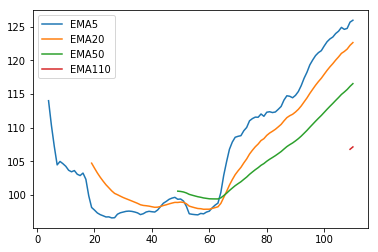

2049
8341
2327
6192
2474
0050
2439
4927


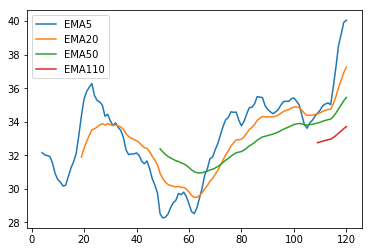

2308


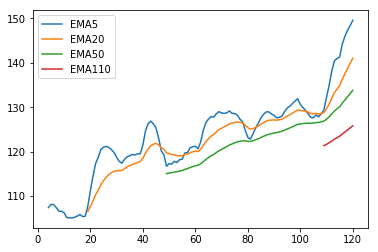

2454
2239
6670
2492
2104
3034
9904


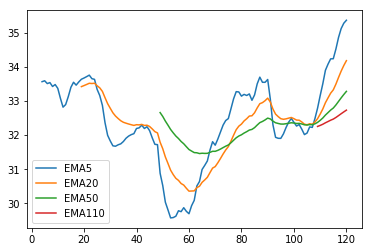

5876
1590


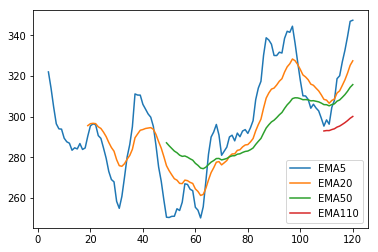

5288


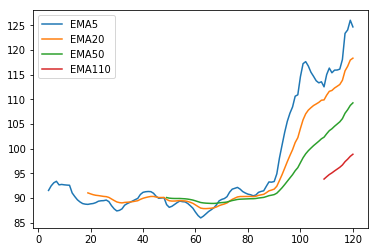

2379


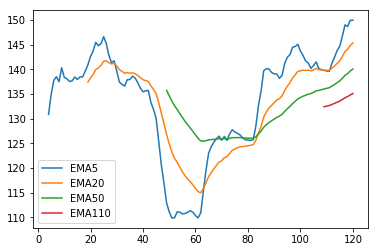

2382


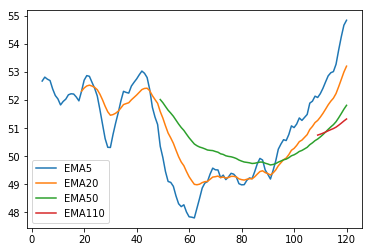

1515


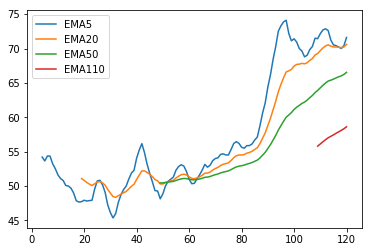

1477


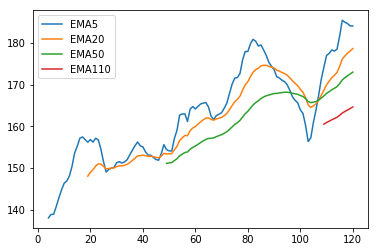

2383
6213
6269
6239
3596


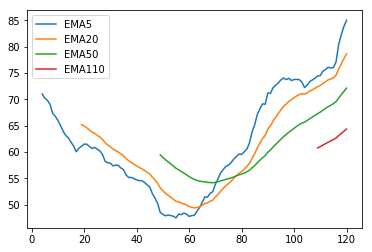

2481
6278


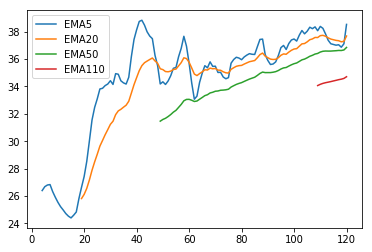

4552
2527
5871


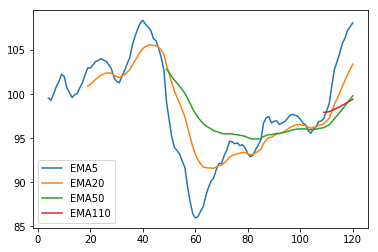

5234
3004


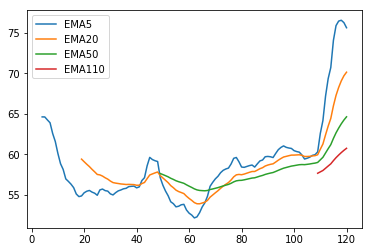

2884
2885


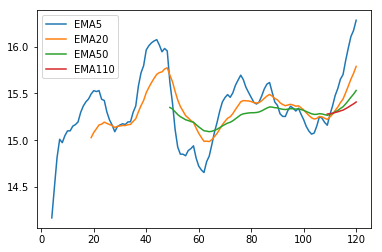

3661
4536


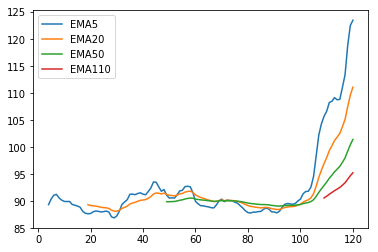

2395


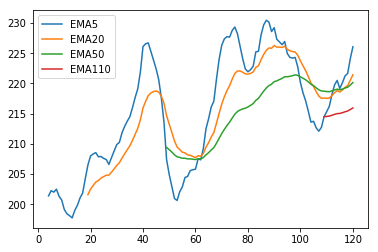

8464


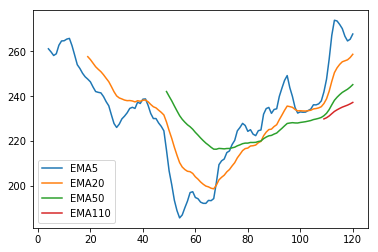

1312
1527
9958
9938
9921


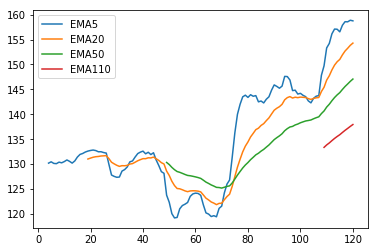

3454


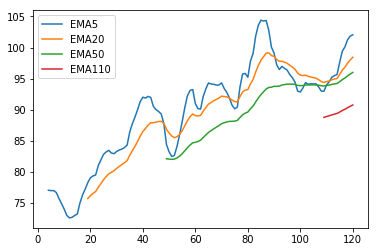

9802


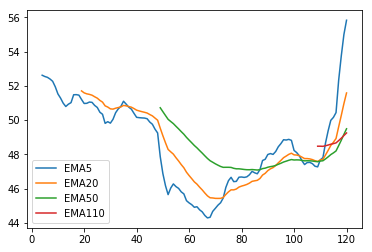

3443
2317
8046


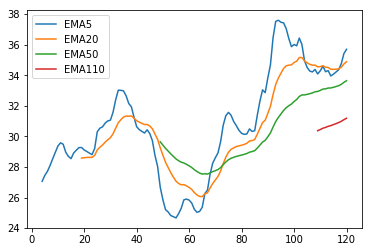

2345


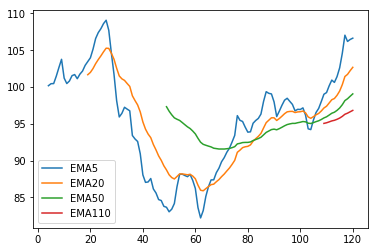

3037
2385


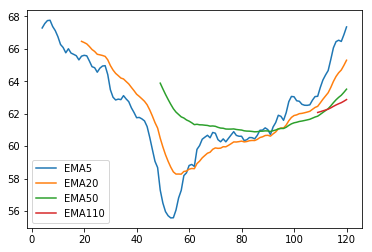

4919
4137


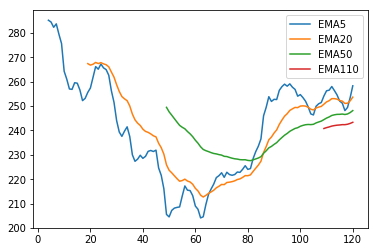

4551


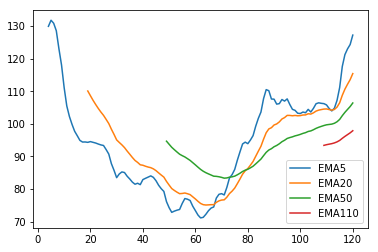

4766
4148
4904
4438
3711
3665
1101
4958
6558
00636
00633L
9914


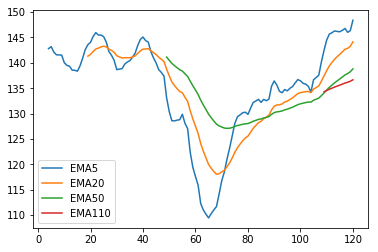

9910


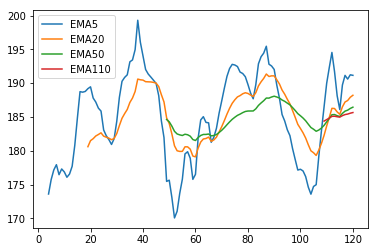

8454


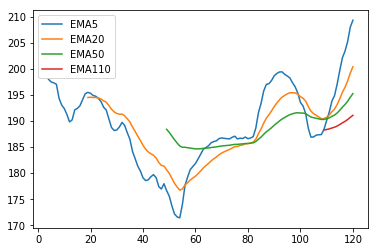

8016


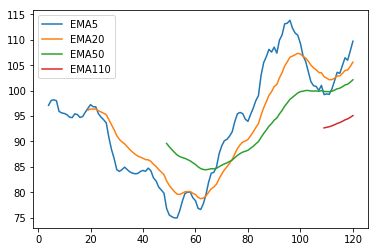

6552
4968
6456
6412
6202
6176
5880
5519


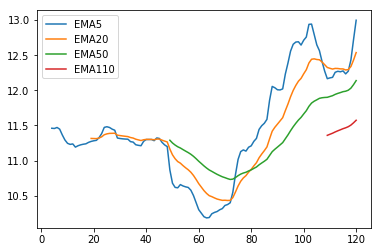

6271
3005


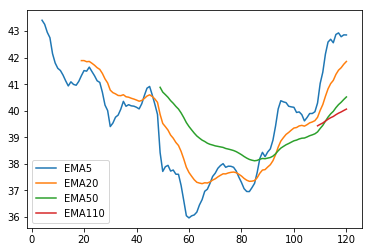

3653


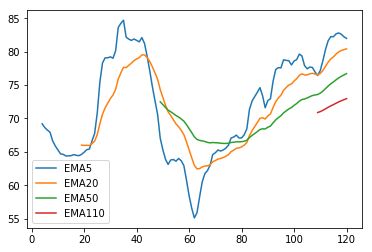

2301


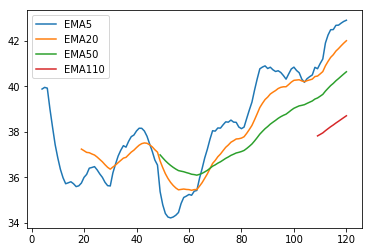

2408
2388
2368


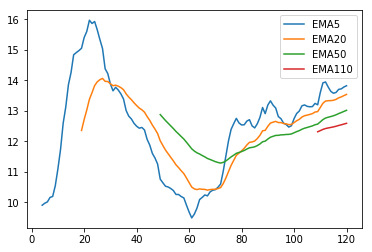

2360
2356
2351
2349
2337
2330
2323


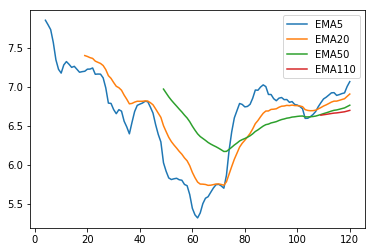

2228


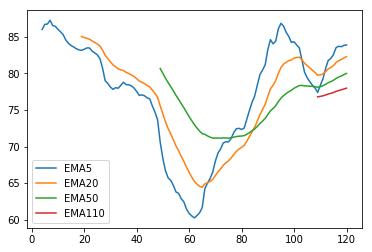

2421
2207


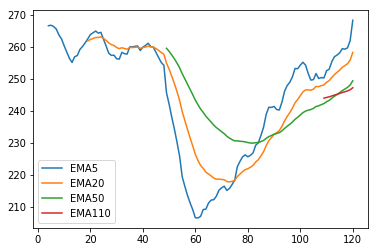

2027
2002
1760
1730


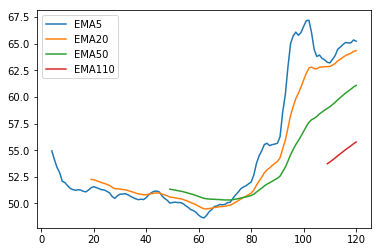

1702
1537


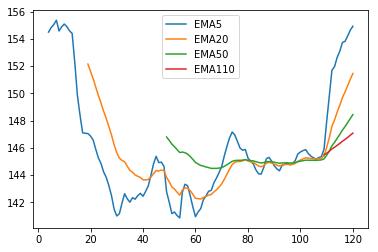

1536
1532
1301
2415
2448
3533


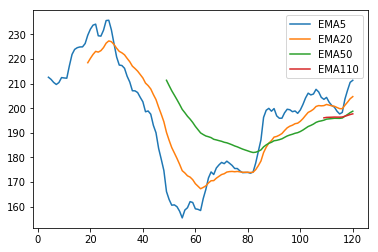

2887
3515
3406
3376
3338


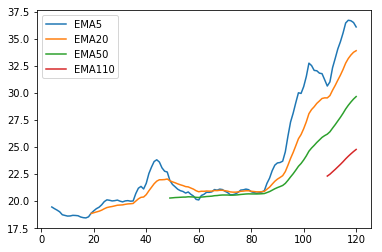

3048
3035
3019
3008
1216
2890
2886
2455
2883
2880
2801
2634


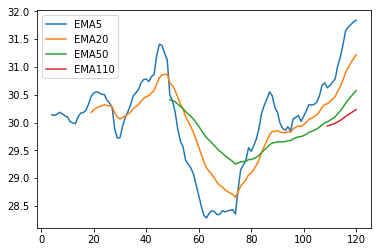

2633


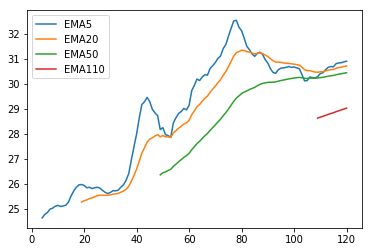

2548


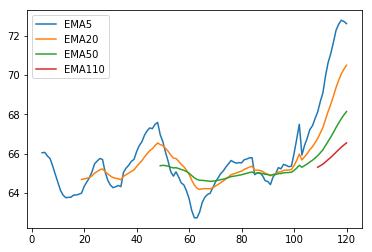

2542
2520
2458


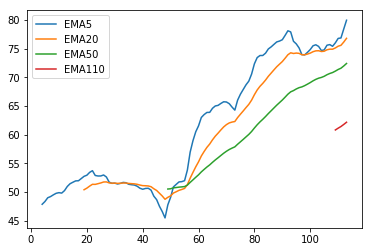

2457
00637L


In [29]:
import talib # for calculating exponential moving average. This API cannot be installed by using the 'pip' command
def MA(xxx):
    EMA5 = talib.EMA(xxx,5)
    EMA20 = talib.EMA(xxx,20)
    EMA50 = talib.EMA(xxx,50)
    EMA110 = talib.EMA(xxx,110)
#    print("EMA5[-1]",EMA5[-1],"EMA20[-1]",EMA20[-1],"EMA50[-1]", EMA50[-1],"EMA100[-1]",EMA100[-1], "EMA20[-2]",EMA20[-2],"EMA50[-2]",EMA50[-2],"EMA100[-2]",EMA100[-2])
    if EMA5[-1] > EMA20[-1] and EMA20[-1] > EMA50[-1] and EMA50[-1] >EMA110[-1] and EMA20[-1] > EMA20[-2] and EMA50[-1] > EMA50[-2] and EMA110[-1] > EMA110[-2]:
# EMA5 > EMA20 > EMA50 > EMA100 , and the slope of EMA20, EMA50 and EMA100 must be positive
        plt.plot(EMA5)
        plt.plot(EMA20)
        plt.plot(EMA50)
        plt.plot(EMA110)
        plt.gca().legend(('EMA5','EMA20','EMA50','EMA110'))
 # plot and see if the EMAs satisfy the stock screening criteria
        plt.show()
        return True
    else:
        return False
res_list= []
df_res = []
for i in range(len(c[0])):
    print(c[0][i])
    load = pd.DataFrame()
# load data within recent 6 months from https://stock.wearn.com
    load = load_df(c[0][i],6)   
    xxx = np.array(load['收盤價'],dtype=float)[::-1] 
# Check if 
    if MA(xxx):
        res_list.append(c[0][i] +'  '+c[1][i])
        df_res.append(load)

In [30]:
# Show the stocks we've picked
for i in range(len(res_list)):
    print(res_list[i])
#    display(df_res[i])
print(str(len(res_list)) + " items")

8482  商億-KY         
4927  泰鼎-KY         
2308  台達電          
9904  寶成            
1590  亞德客-KY       
5288  豐祥-KY         
2379  瑞昱            
2382  廣達            
1515  力山            
1477  聚陽            
3596  智易            
6278  台表科          
5871  中租-KY         
3004  豐達科          
2885  元大金          
4536  拓凱            
2395  研華            
8464  億豐            
9921  巨大            
3454  晶睿            
9802  鈺齊-KY         
8046  南電            
2345  智邦            
2385  群光            
4137  麗豐-KY         
4551  智伸科          
9914  美利達          
9910  豐泰            
8454  富邦媒          
8016  矽創            
5519  隆大            
3005  神基            
3653  健策            
2301  光寶科          
2368  金像電          
2323  中環            
2228  劍麟            
2207  和泰車          
1730  花仙子          
1537  廣隆            
3533  嘉澤            
3338  泰碩            
2634  漢翔            
2633  台灣高鐵        
2548  華固            
2458  義隆            
46 items


<font color=#990011 size=6>Backtesting:</font><br>
<font color=#002200 size=5>Use a modified double crossover method instead. Follow a set of criteria：</font><br>
<font color=#00aa00 size=4>．Buy：</font><br>
<font color=#009988 size=3>ⅰ. stock price > short EMA<br></font>
<font color=#009988 size=3>ⅱ. slope of short and long EMA > 0<br></font>
<font color=#009988 size=3>ⅲ. ( short EMA / long EMA ) > 1.02<br></font>
<font color=#009988 size=3>ⅳ. current price > EMA50<br></font>
<font color=#00aa00 size=4>．Sell：</font><br>
<font color=#009988 size=3> slope of short EMA < 0 </font> <font color=#aa0088 size=3>(when there is a pullback)<br></font>
or <br>
<font color=#009988 size=3>( slope of short EMA > 0 and trading volume > 2.2*(yesterday’s) )</font> <font color=#aa0088 size=3>(when there is a volume surge)<br></font>

In [28]:
#crawl data within the last two years (24 months) from https://stock.wearn.com, very time-consuming
backtest_df = []
res_list = [x.split(' ')[0] for x in res_list]
print(res_list)
for i in res_list:
    backtest_temp = load_df(i,24)
    backtest_df.append(backtest_temp)
    backtest_temp.to_csv(str(i)+'.csv',sep=',',encoding='utf-8')
    display(backtest_temp)

['8482']


KeyError: '日期'

<font color=#990099 size=5>calculate ROI and win rate</font><br>

In [12]:
# roi& winrate
def roical(buyprice, sellprice, winrate):
    roi = (float(sellprice)-float(buyprice)*1.005)/float(buyprice)
    if roi > 0:
        winrate += 1
    return (roi, winrate)

In [13]:
# Backtesting
def calculate_winrate(df,short,long):
    EMA_short = talib.EMA(df["收盤價"][::-1],short)
    EMA_long = talib.EMA(df["收盤價"][::-1],long)
    EMA50 = talib.EMA(df["收盤價"][::-1],50)
    newdff = df.copy()
    str_short = "EMA"+ str(short)
    str_long = "EMA" + str(long)
    newdff[str_short] = EMA_short
    newdff[str_long] = EMA_long
    newdff["EMA50"] = EMA50
# initialize the dates and prices when buying and selling stocks
    newdff['XBuy'] = np.nan
    newdff['YBuy'] = np.nan
    newdff['XSell'] = np.nan
    newdff['YSell'] = np.nan
    newdff = newdff.loc[(newdff["EMA50"] > 0)]
    row = len(newdff)  # the number of row in the dataframe
# initialize some variables
    flag = False       # stock brought → True， stock sold → False
    change = 0         # the ratio of two EMAs
    buyprice = 0       # closing price when the stock is bought
    sellprice = 0      # closing price when the stock is sold
    roi = 0            # ROI
    acmroi = 0         # cumulative ROI
    count = 0          # transaction count
    winrate = 0        # win rate

    for i in range(0,row-1)[::-1]:
        change = newdff[str_short].iloc[i]/newdff[str_long].iloc[i]
        change2 = newdff[str_long].iloc[i]/newdff["EMA50"].iloc[i]
        if (flag==False) and (float(newdff["收盤價"].iloc[i]) > float(newdff[str_short].iloc[i]) > float(newdff[str_short].iloc[i+1])) \
        and (float(newdff[str_long].iloc[i]) > float(newdff[str_long].iloc[i+1])) and (change > 1.02) \
        and (float(newdff["收盤價"].iloc[i]) > float(newdff["EMA50"].iloc[i])):          
            newdff = newdff.copy()
            newdff.loc[i,"XBuy"] = newdff.loc[i,"日期"]
            newdff.loc[i,"YBuy"] = newdff.loc[i,"收盤價"]
            buyprice = newdff["收盤價"].iloc[i]
            count+=1
            flag = True
        if (flag==True) and ((newdff[str_short].iloc[i] < newdff[str_short].iloc[i+1]) or \
( (newdff[str_short].iloc[i] > newdff[str_short].iloc[i+1]) and float(newdff["成交量"].iloc[i])/float(newdff["成交量"].iloc[i]) > 2.2)):
            newdff = newdff.copy()
            newdff.loc[i,"XSell"] = newdff.loc[i,"日期"]
            newdff.loc[i,"YSell"] = newdff.loc[i,"收盤價"]
            sellprice = newdff["收盤價"].iloc[i]
            count+=1
            flag = False
            [roi, winrate] = roical(buyprice, sellprice, winrate)
            acmroi += roi
        if (flag == True and i==0):
            newdff = newdff.copy()
            newdff.loc[i,"XSell"] = newdff.loc[i,"日期"]
            newdff.loc[i,"YSell"] = newdff.loc[i,"收盤價"]
            sellprice = newdff["收盤價"].iloc[i]
            count+=1
            [roi, winrate] = roical(buyprice, sellprice, winrate)
            acmroi += roi
#    display(newdff)
    if count == 0:
        winrate = 0
    else:
        winrate = winrate/(count/2)
    return count, acmroi, winrate

In [14]:
# Obtain an EMA pair that correspond to the highest ROI for individual stocks.
def find_MA(df_xx):
    temp_res = []
    temp = -np.inf
    for ishort in range(2,8):
        for ilong in range(12,21):
            temp_count, temp_acmroi, temp_winrate = calculate_winrate(df_xx,ishort,ilong)
            if temp_acmroi > temp:
                temp_res = [temp_count,temp_acmroi,temp_winrate,ishort,ilong]
                temp = temp_acmroi
    print(temp_res)
    return temp_res
roi_list = []
for ix in range(len(df_res)):
    print(res_list[ix])
    roi_list.append(find_MA(backtest_df[ix]))

2610
[28, 0.21396936437246597, 0.2857142857142857, 3, 16]
2618
[4, 0.02292952000333069, 0.5, 3, 13]
6176
[18, -0.13334086785577087, 0.3333333333333333, 6, 15]
6230
[24, 0.18182258658546818, 0.5, 4, 13]
5288
[2, 0.16724880382775126, 1.0, 6, 12]
2301
[0, 0, 0, 7, 12]
1434
[0, 0, 0, 7, 12]
3653
[66, -0.1650836981597597, 0.2727272727272727, 2, 13]
2379
[46, -0.16461611912263574, 0.34782608695652173, 5, 20]
3665
[46, -0.0040913094574704795, 0.34782608695652173, 7, 20]
3338
[14, 0.36419384690957696, 0.42857142857142855, 6, 14]
1532
[2, 0.12833333333333347, 1.0, 6, 12]
00638R
[8, 0.0036916657552322303, 0.5, 4, 13]
6285
[0, 0, 0, 6, 12]
8499
[12, 0.018314941065808315, 0.3333333333333333, 7, 20]
4763
[8, 0.03882428276829909, 0.75, 5, 12]
8046
[24, 0.04230575401107526, 0.4166666666666667, 4, 13]
2501
[0, 0, 0, 7, 12]
3037
[14, -0.044024043061084706, 0.2857142857142857, 7, 12]


In [16]:
# write to csv (stock ID, transcation count, ROI, win rate)
from itertools import zip_longest
trans_count = [roi_list[i][0] for i in range(len(roi_list))]
roi = [roi_list[i][1] for i in range(len(roi_list))]
win_rate = [roi_list[i][2] for i in range(len(roi_list))]
d = [res_list,trans_count,roi,win_rate]
export_data = zip_longest(*d, fillvalue = '')
with open('id.csv', 'w', newline='') as f:
    wr = csv.writer(f)
    wr.writerow(("Stock id", "Transaction count","ROI","win rate"))
    wr.writerows(export_data)
f.close()

In [17]:
from matplotlib import dates as mdates
def reset_date(value):
    temp = value.split("/")
    temp[0] = str(int(temp[0])+1911) # convert to AD dates
    return "-".join(temp)
def new_dataframe(df):
    df = df[["日期", "開盤價","最高價","最低價","收盤價","成交量"]]
    col = ["開盤價","最高價","最低價","收盤價","成交量"]
    df[col] = df[col].astype(float)
    df['日期'] = df["日期"].map(reset_date).astype('datetime64[D]')
    df['日期'] = df['日期'].map(mdates.date2num)  #Convert datetime objects to Matplotlib dates.
    return df
#new_dataframe(df_res[4])

<br>
<font size=6 color=#000077>Draw candlestick plots to visualize the results</font>
<br><br>

<IPython.core.display.Javascript object>


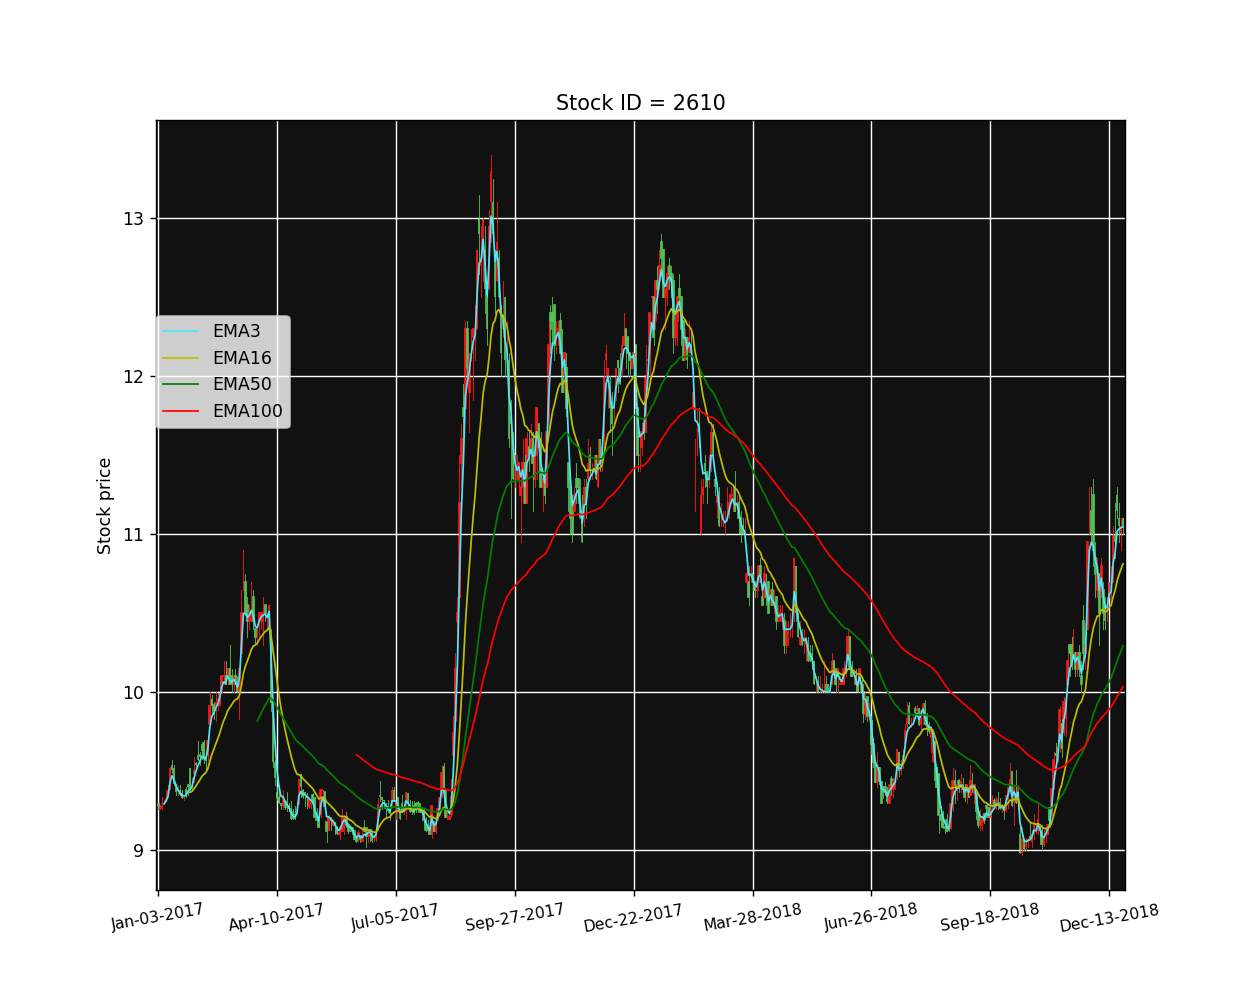

<IPython.core.display.Javascript object>


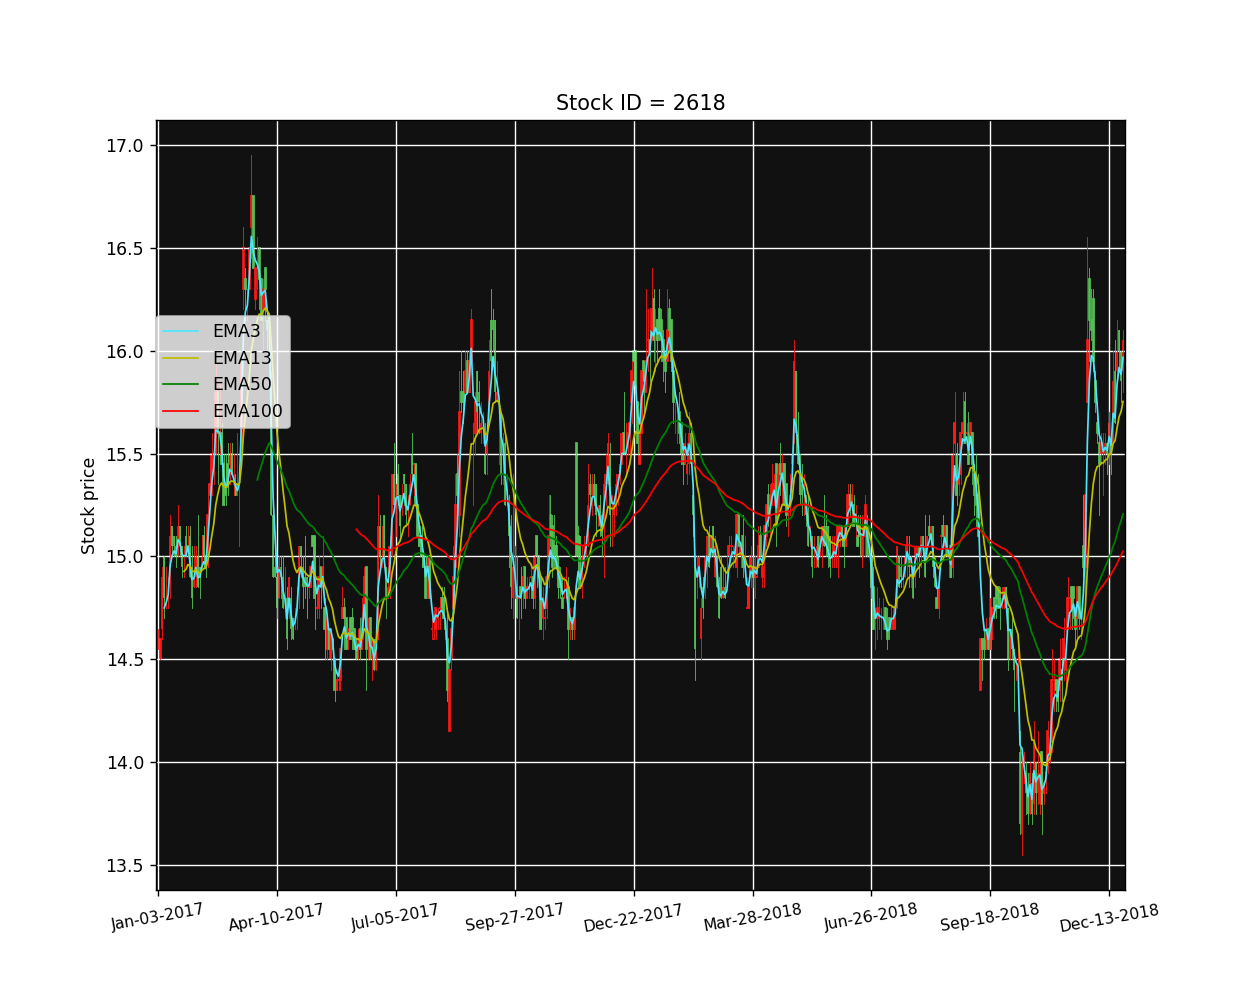

<IPython.core.display.Javascript object>


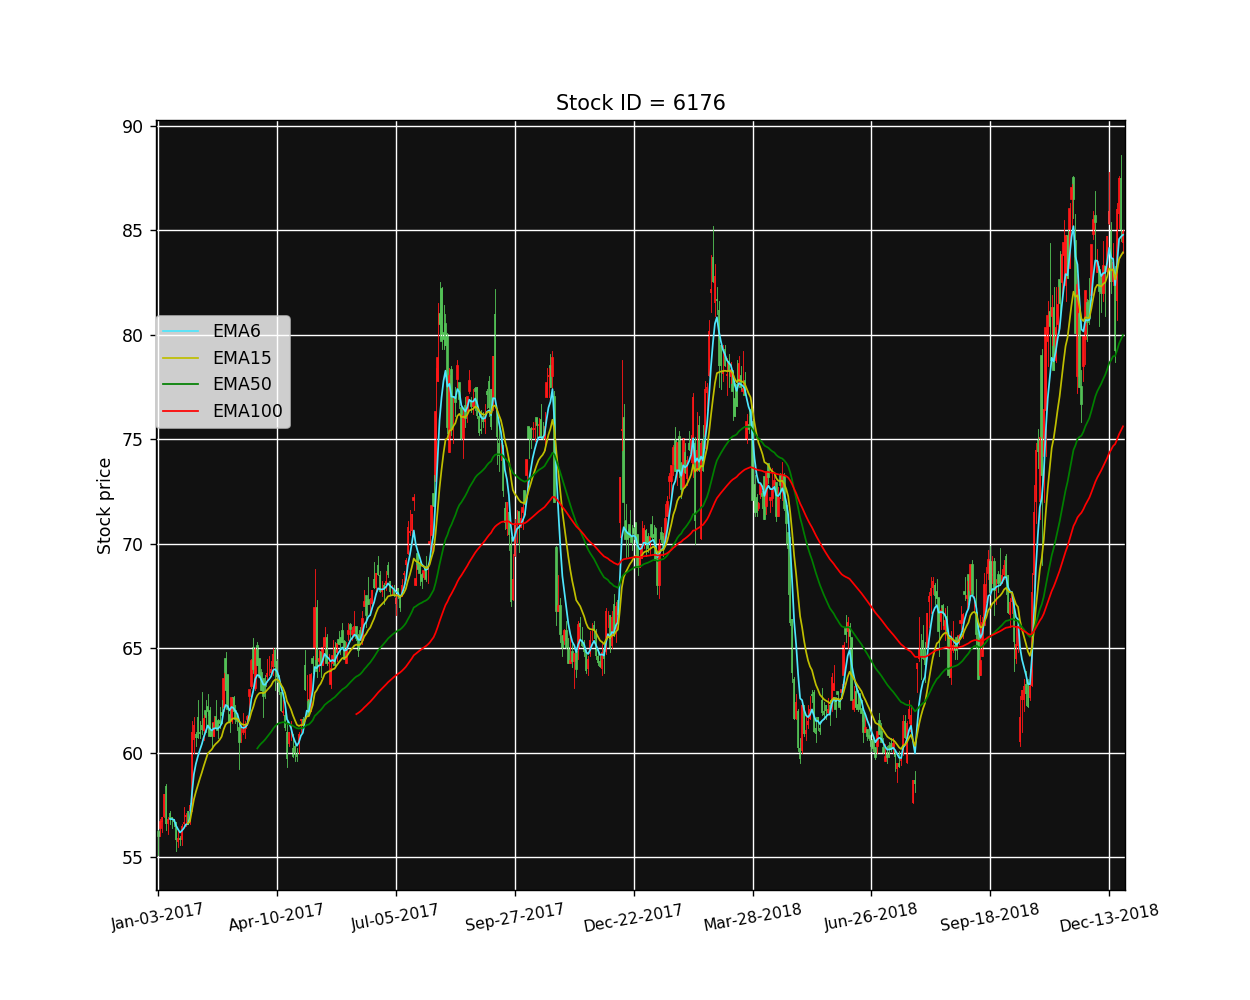

<IPython.core.display.Javascript object>


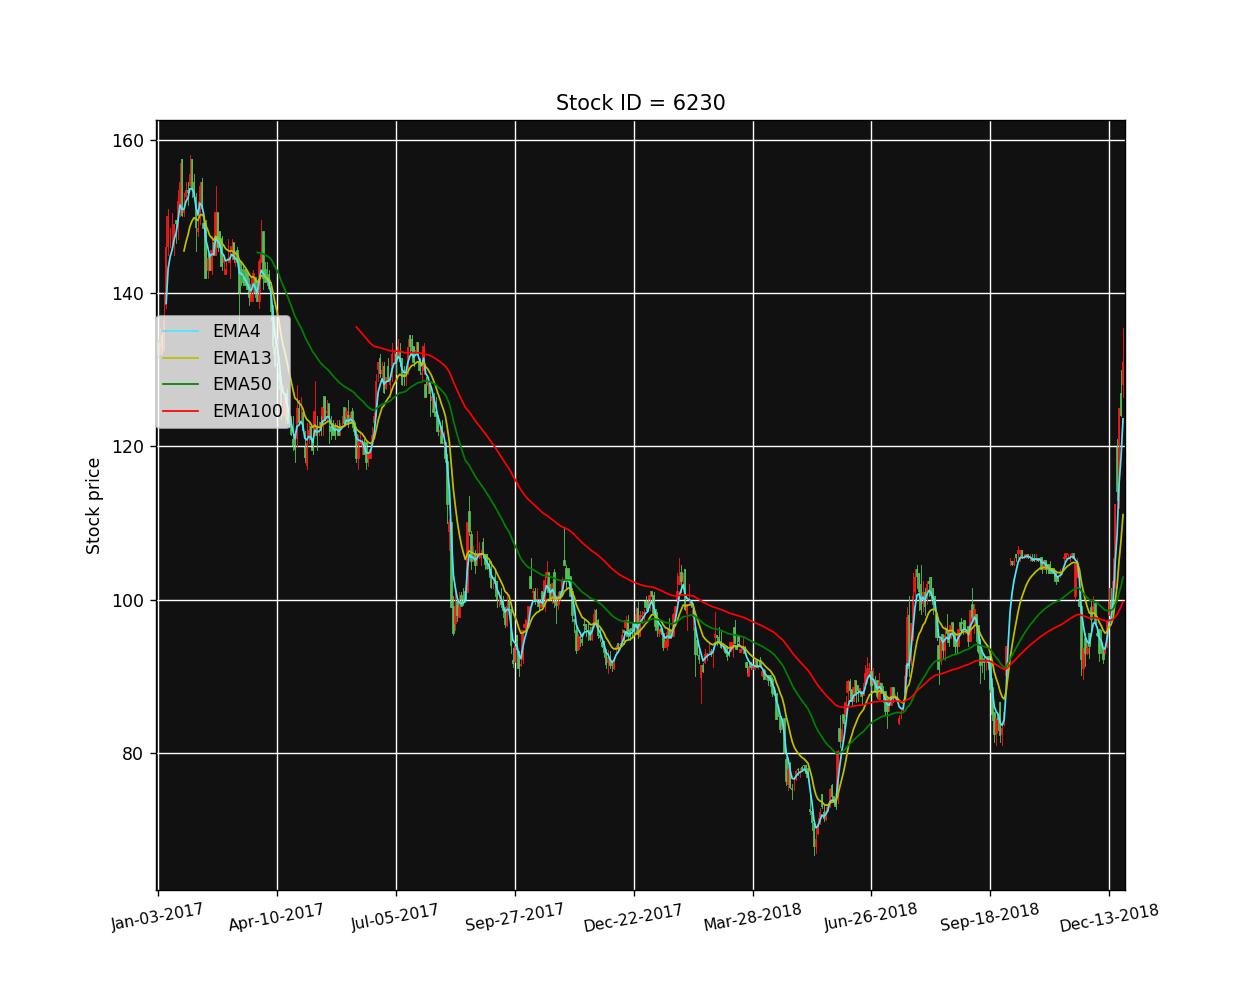

<IPython.core.display.Javascript object>


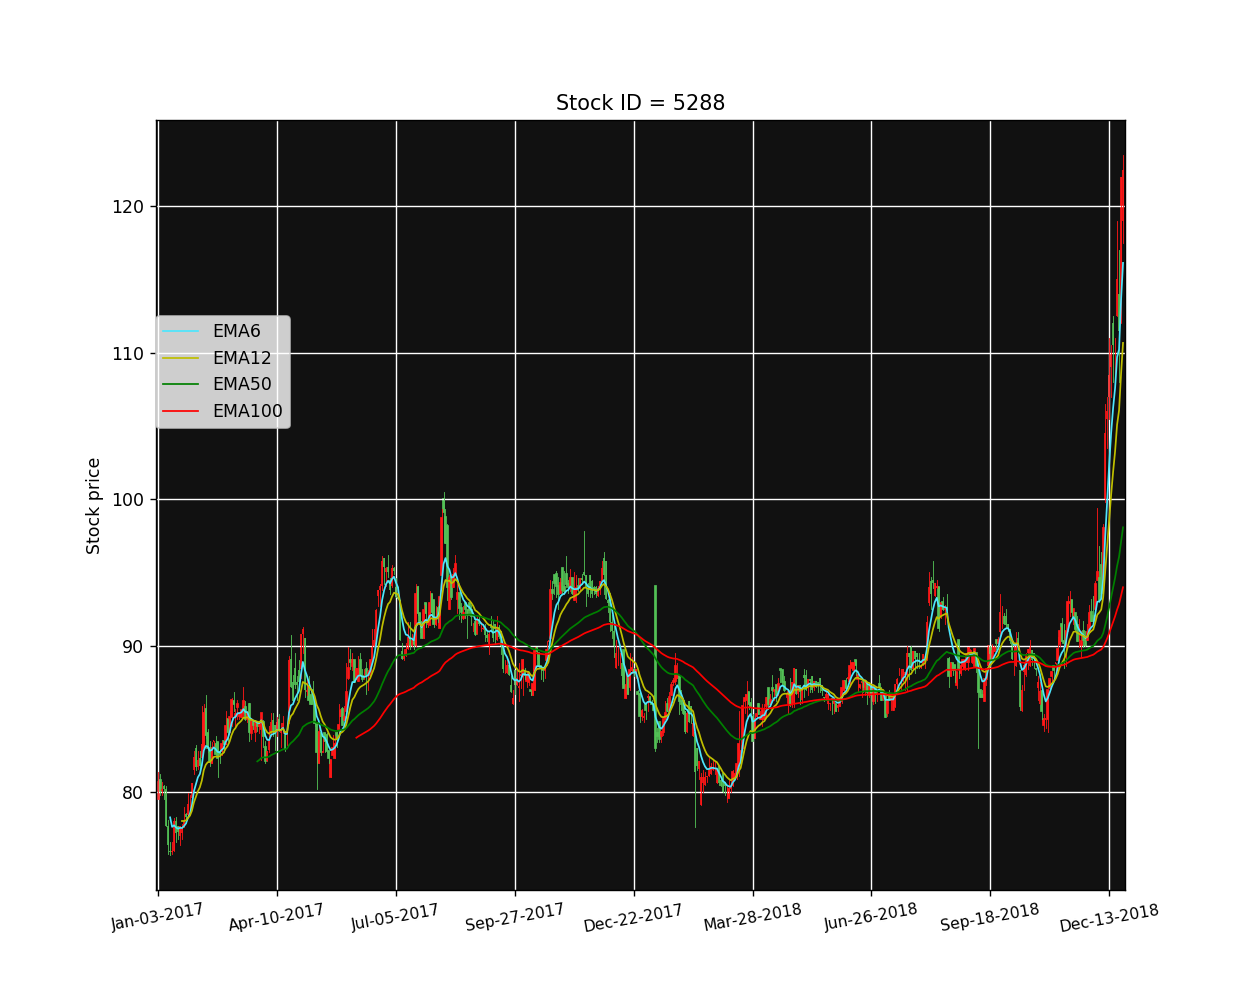

<IPython.core.display.Javascript object>


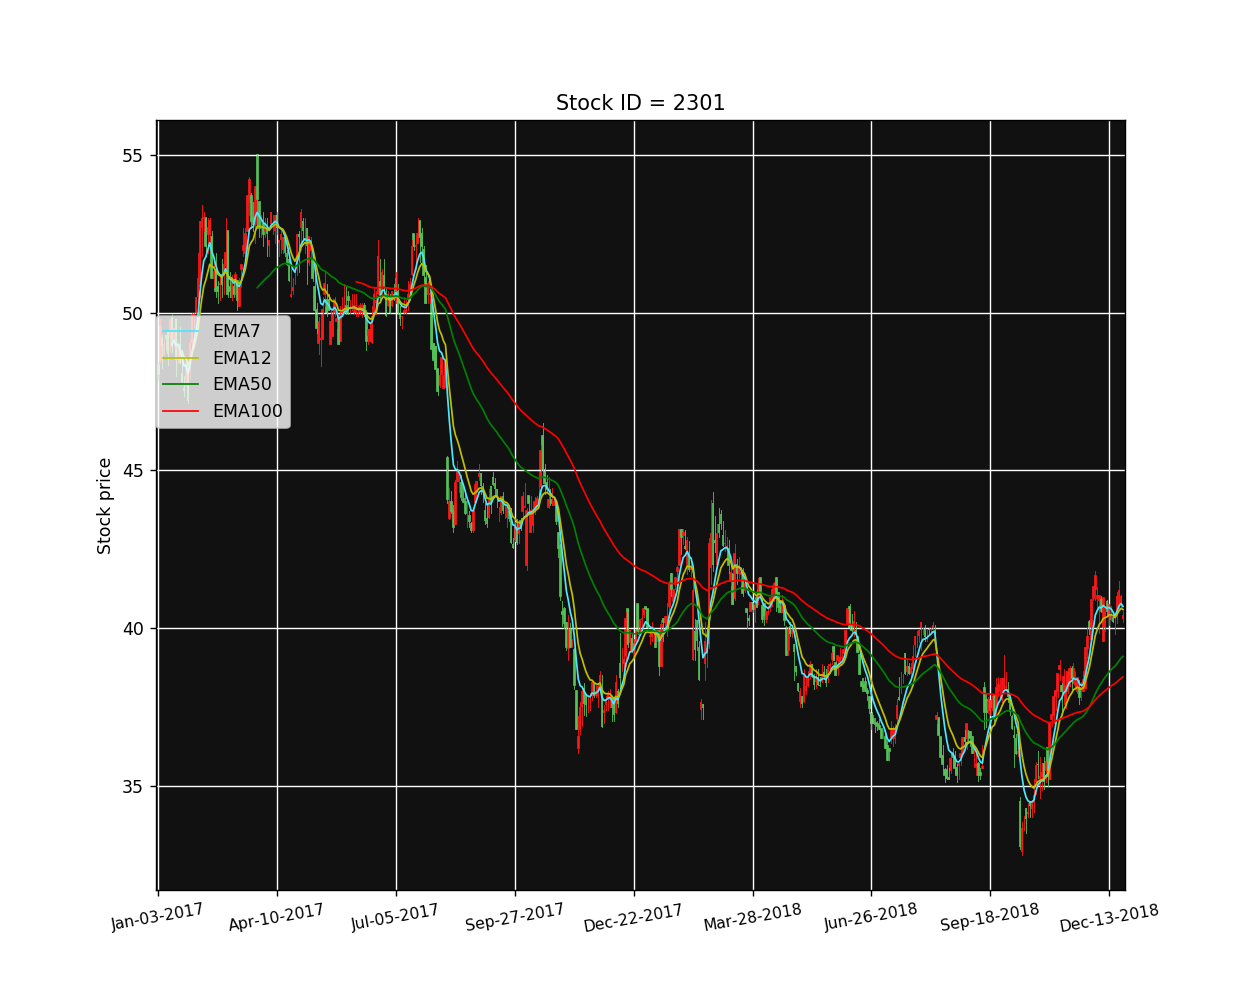

<IPython.core.display.Javascript object>


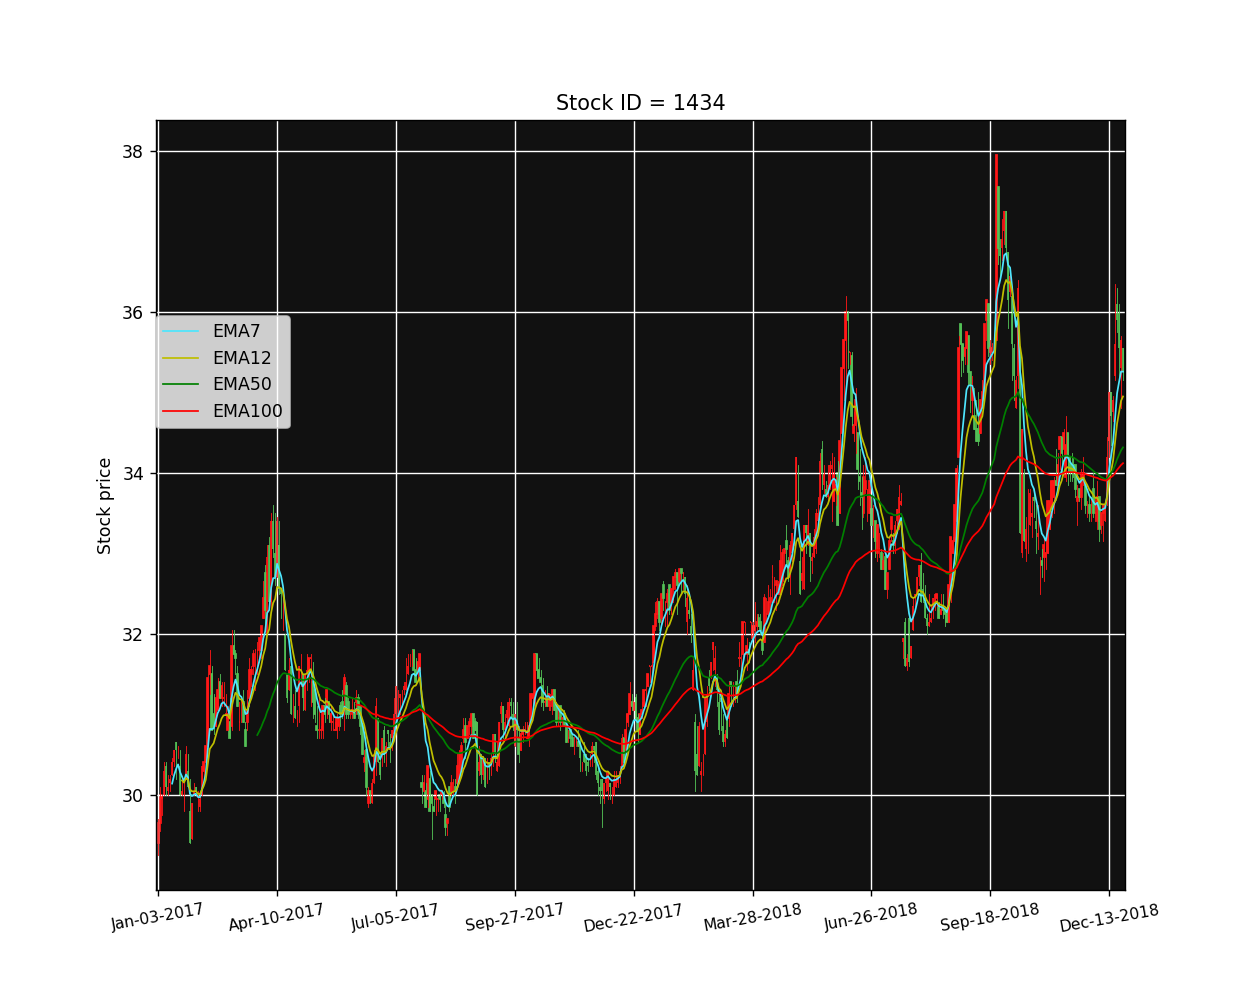

<IPython.core.display.Javascript object>


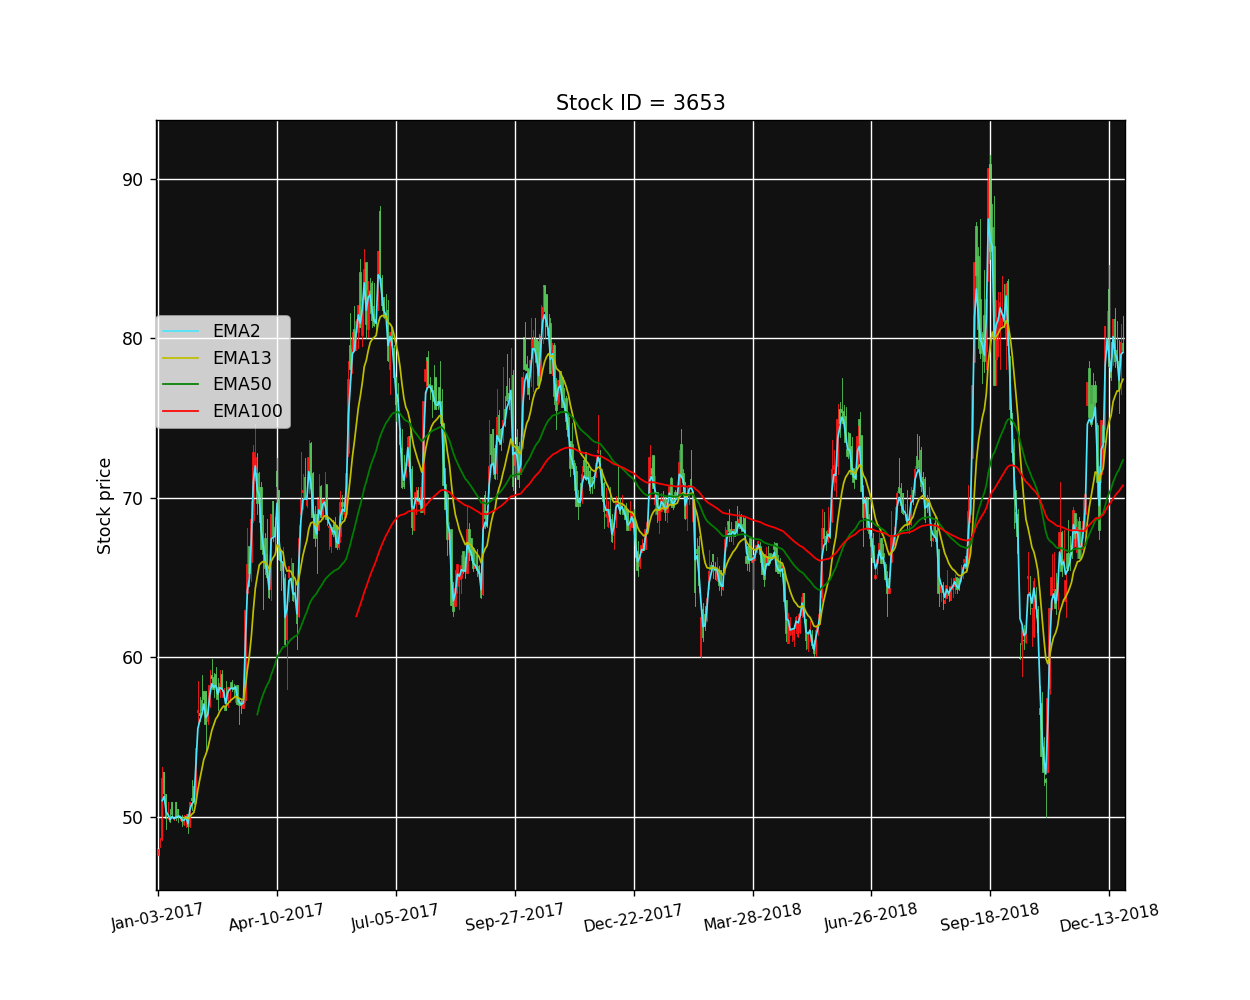

<IPython.core.display.Javascript object>


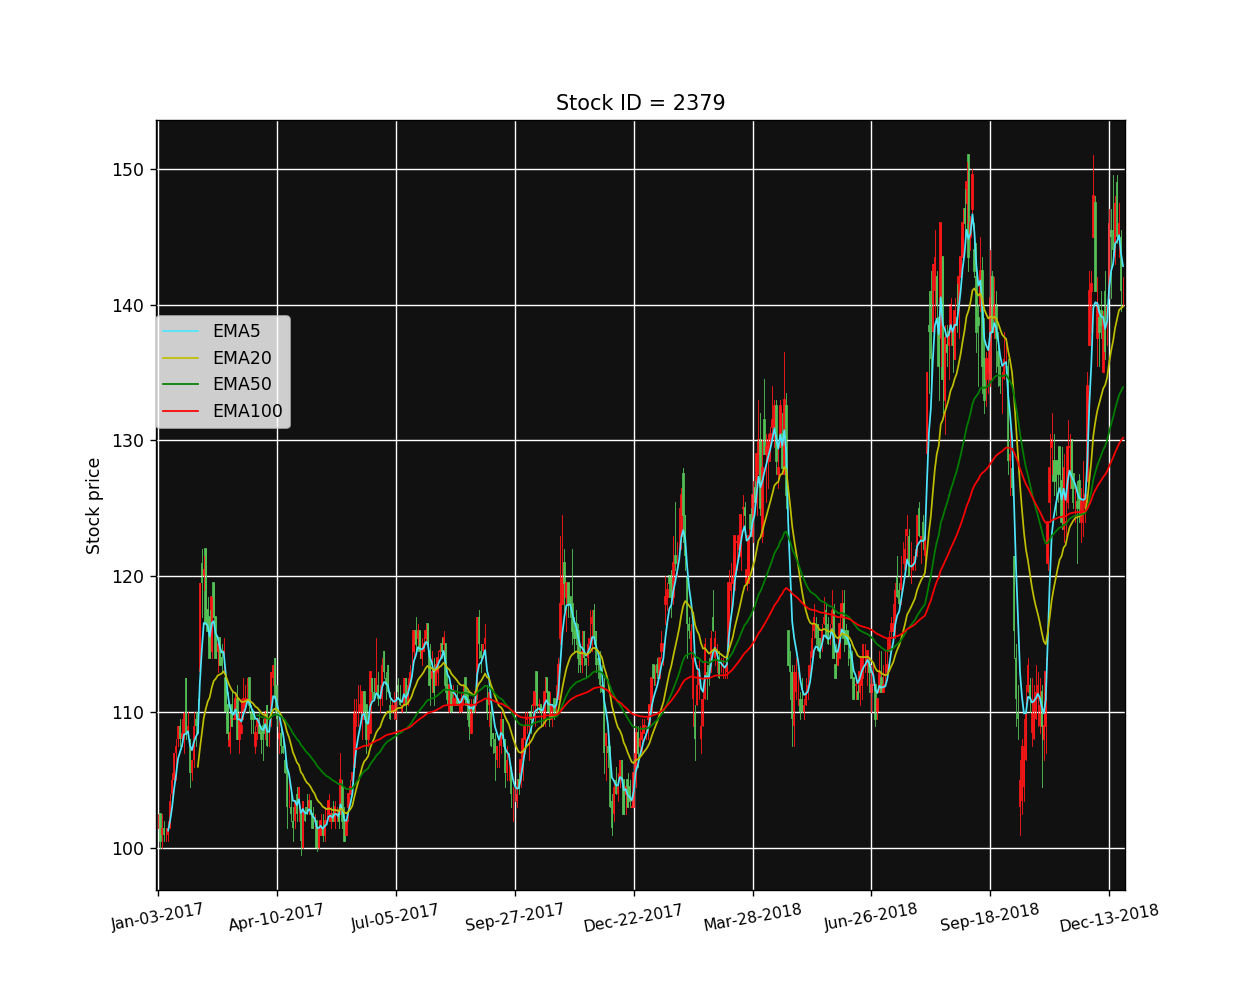

<IPython.core.display.Javascript object>


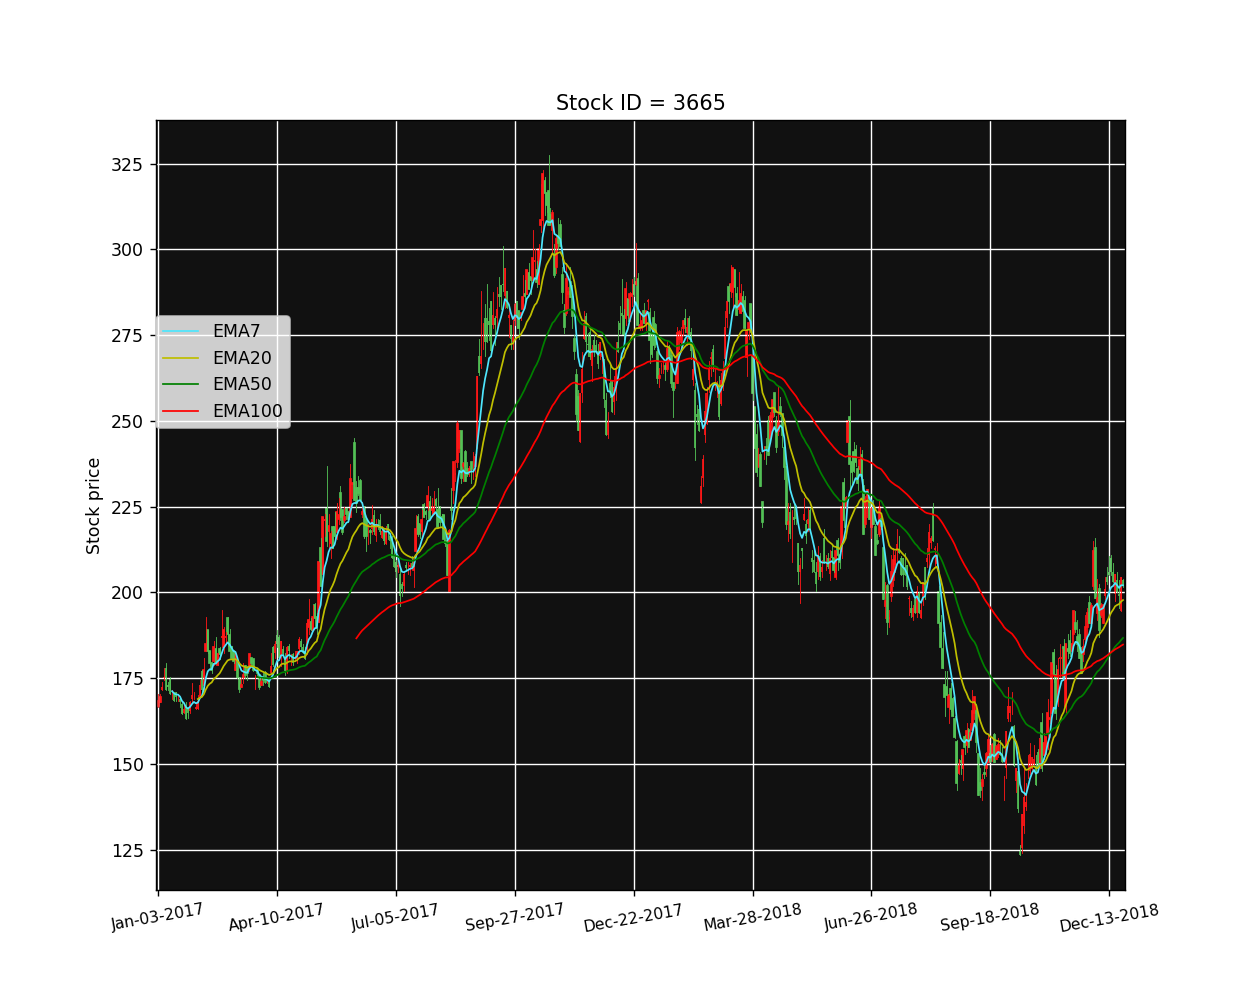

<IPython.core.display.Javascript object>


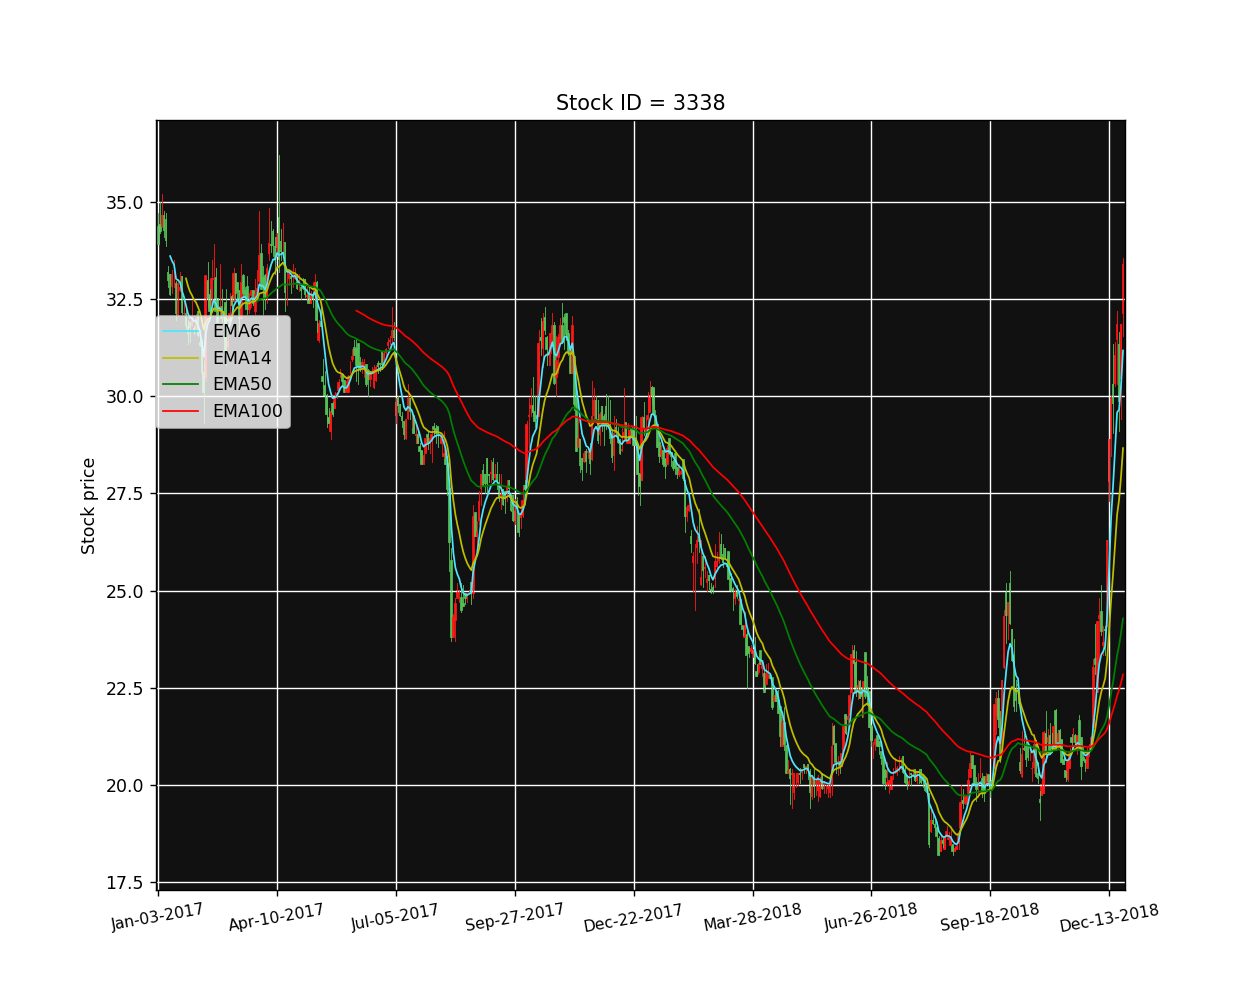

<IPython.core.display.Javascript object>


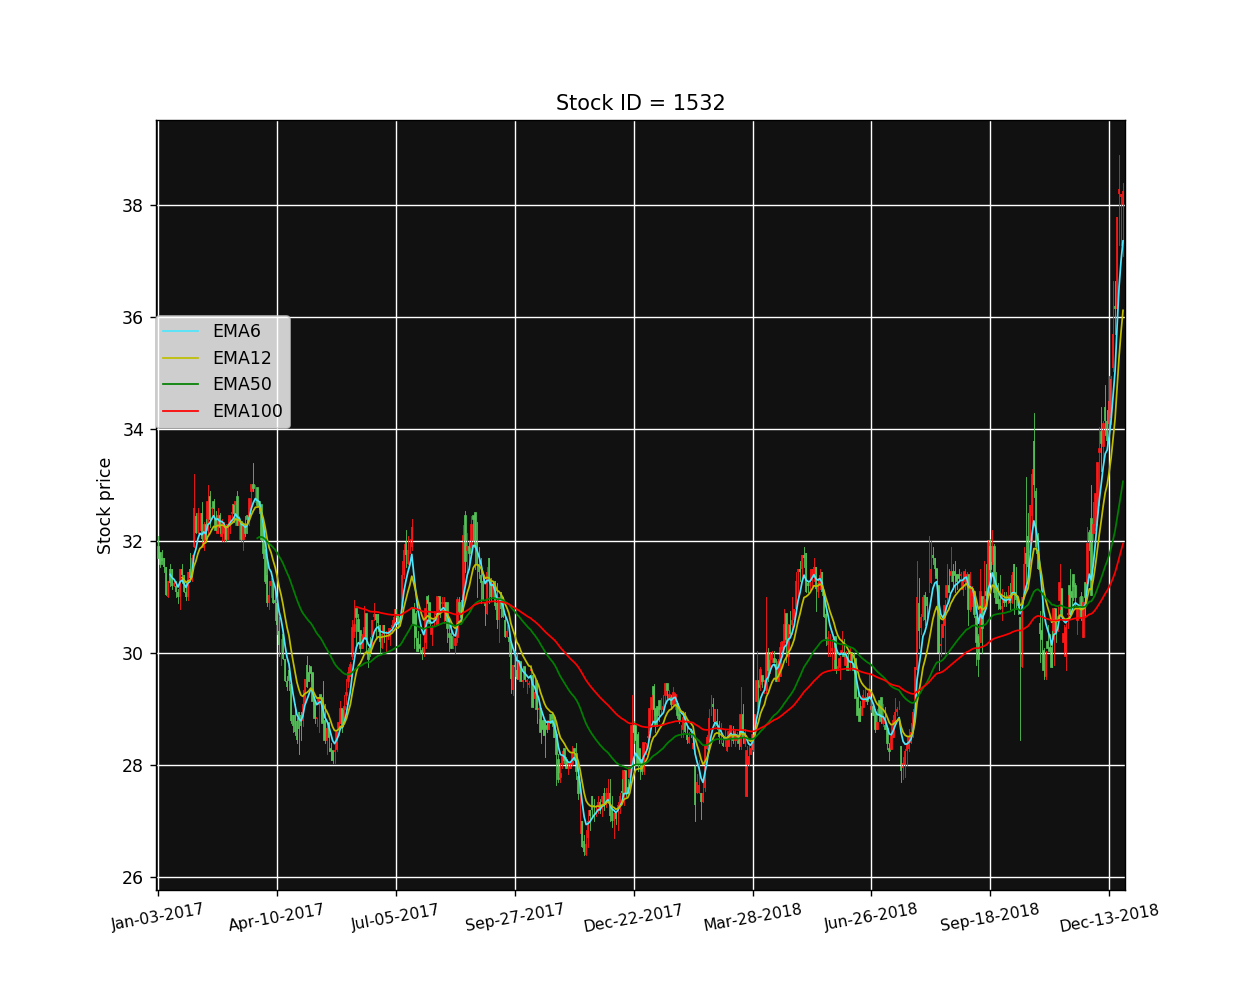

<IPython.core.display.Javascript object>


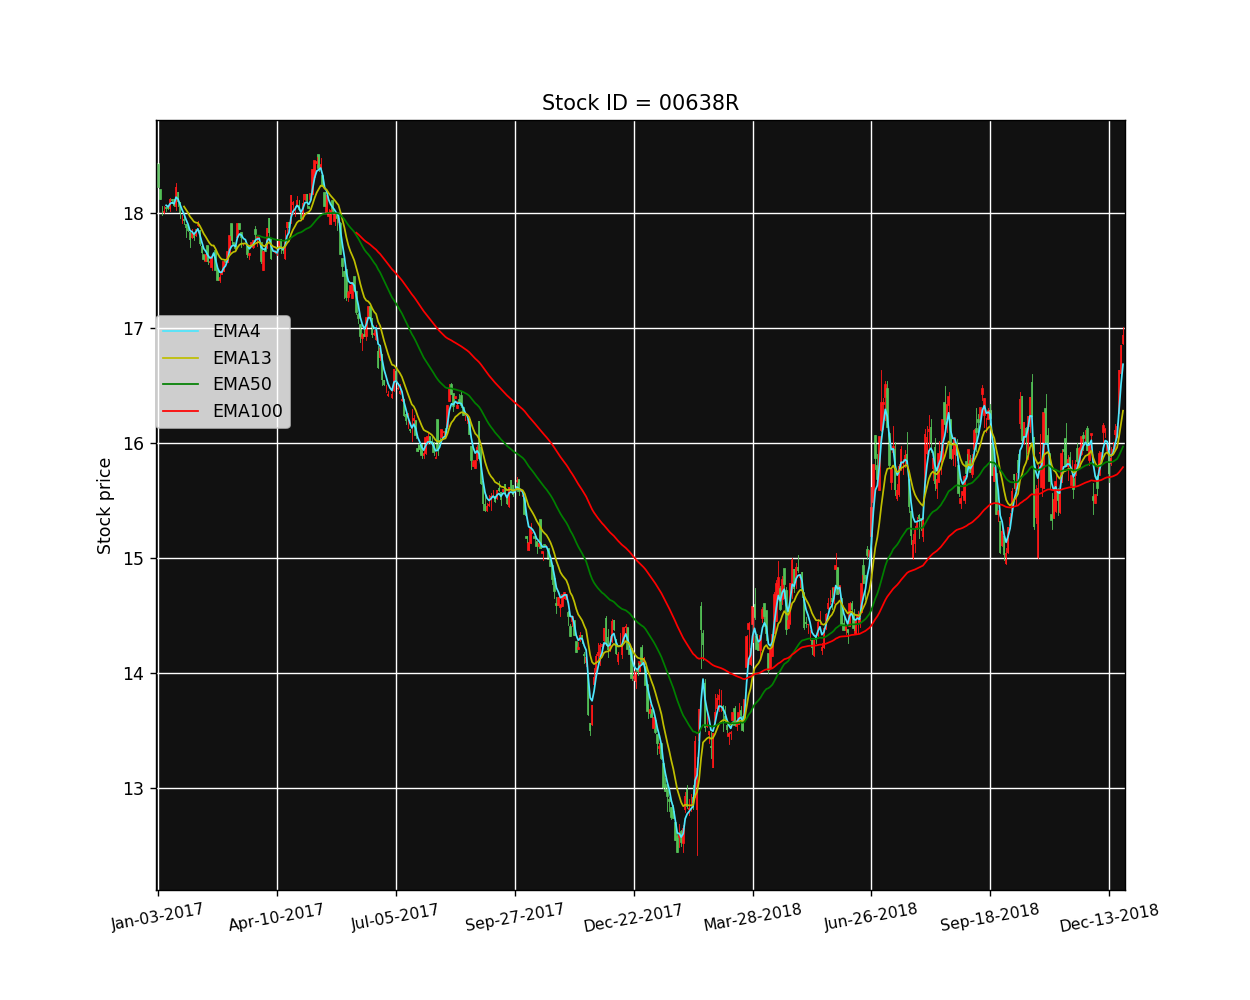

<IPython.core.display.Javascript object>


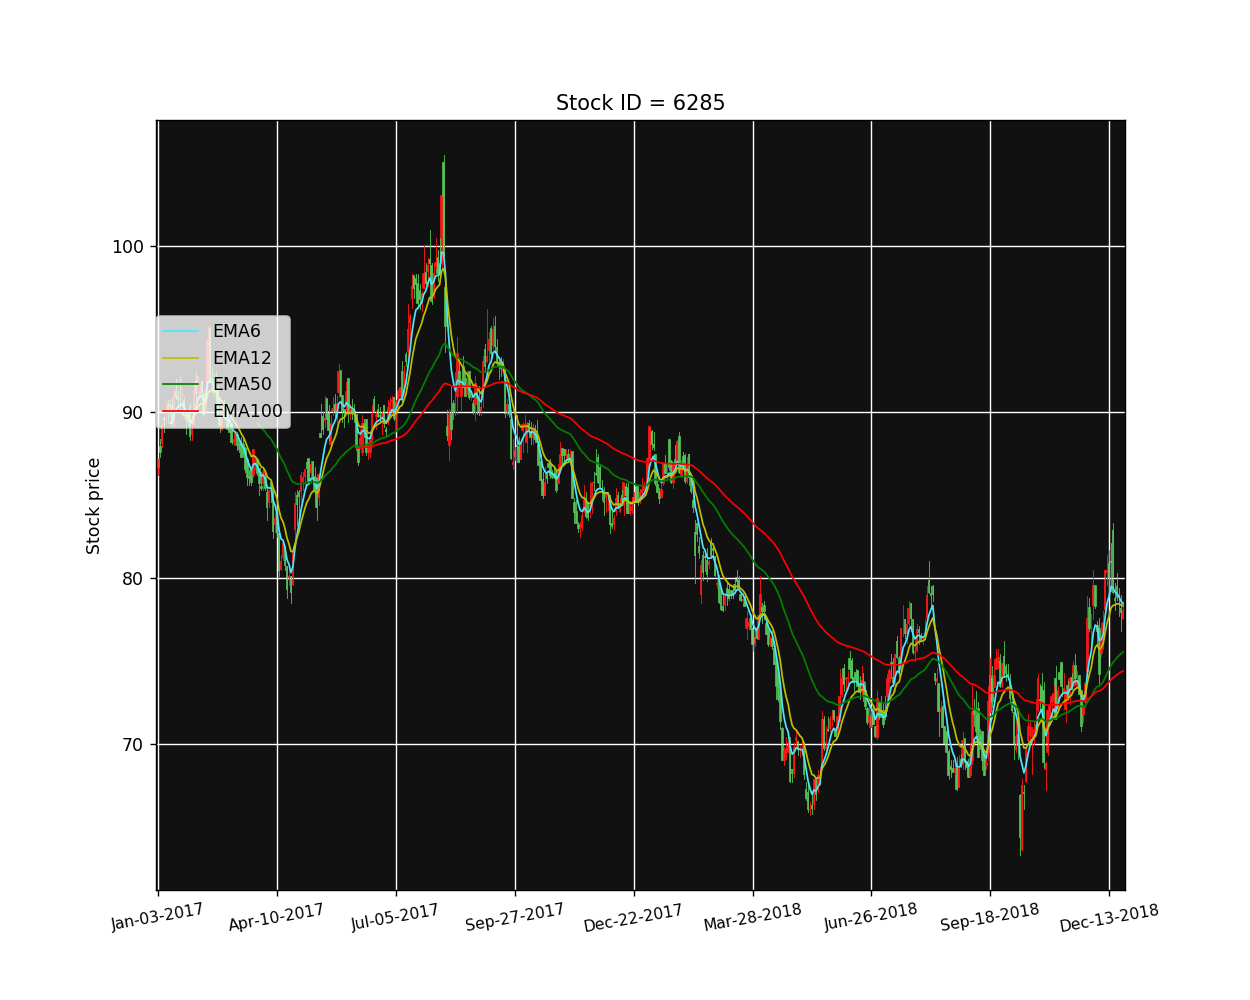

<IPython.core.display.Javascript object>


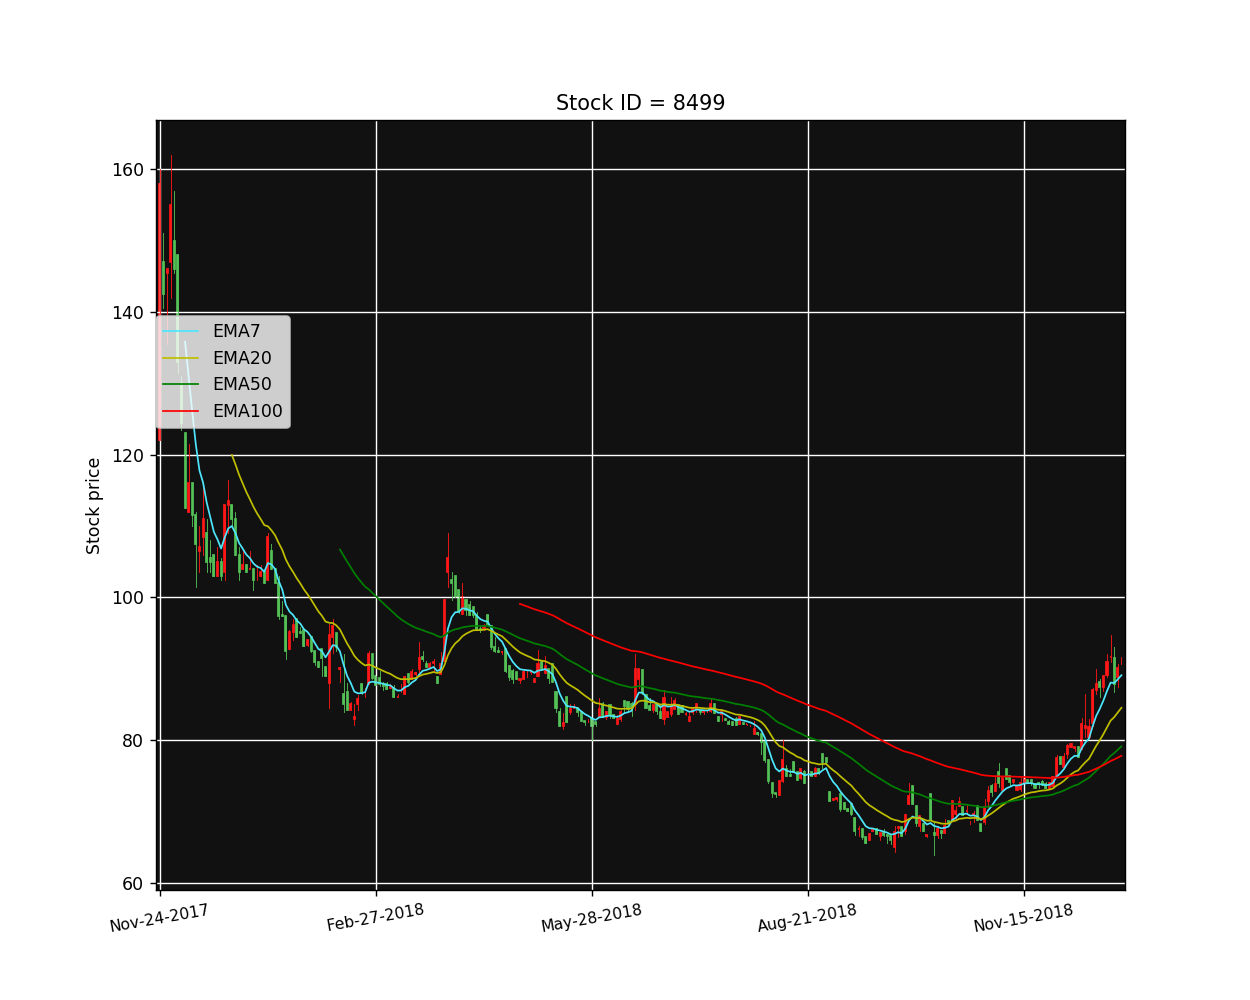

<IPython.core.display.Javascript object>


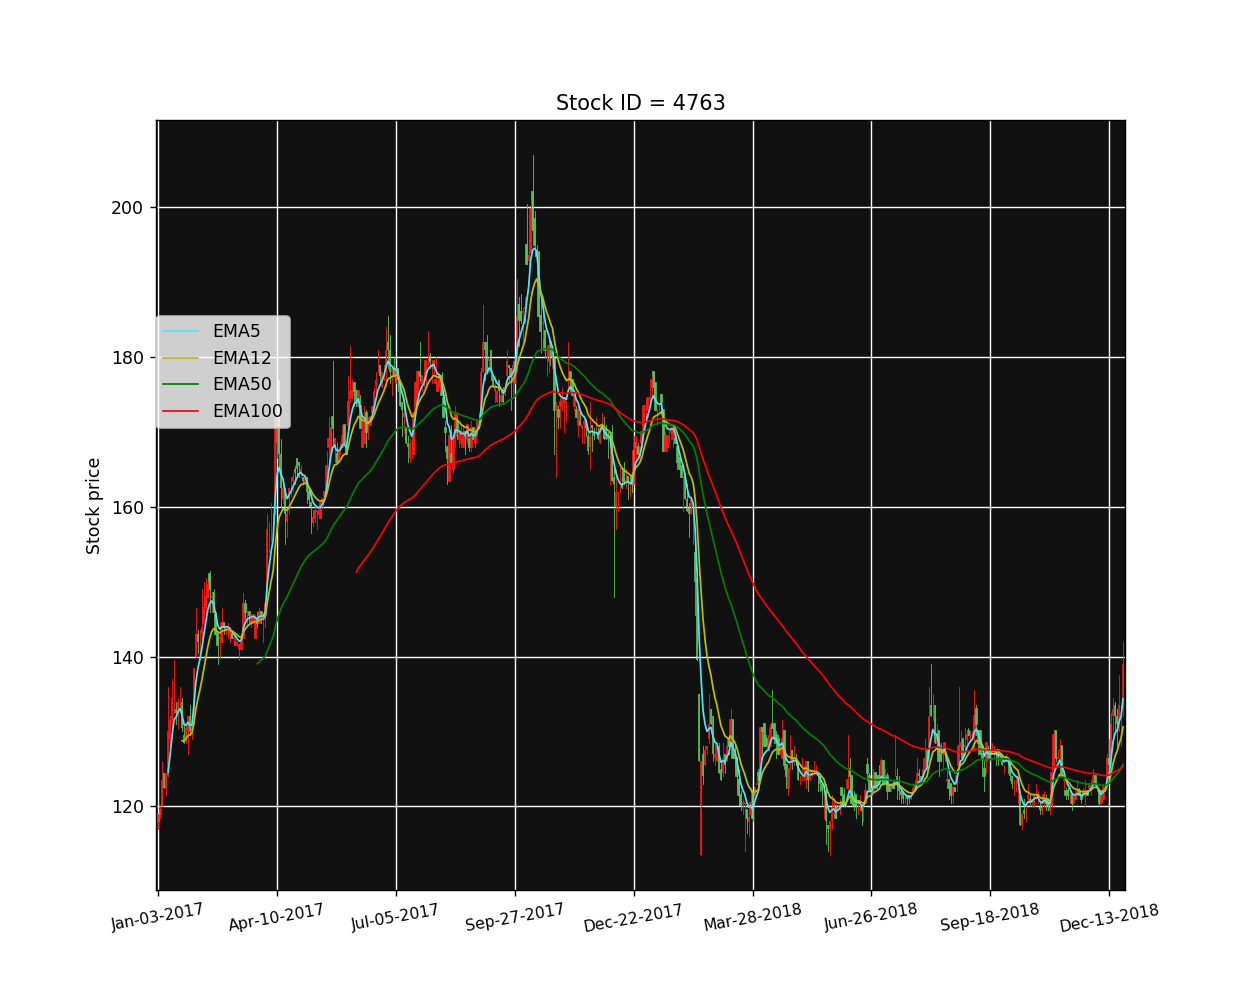

<IPython.core.display.Javascript object>


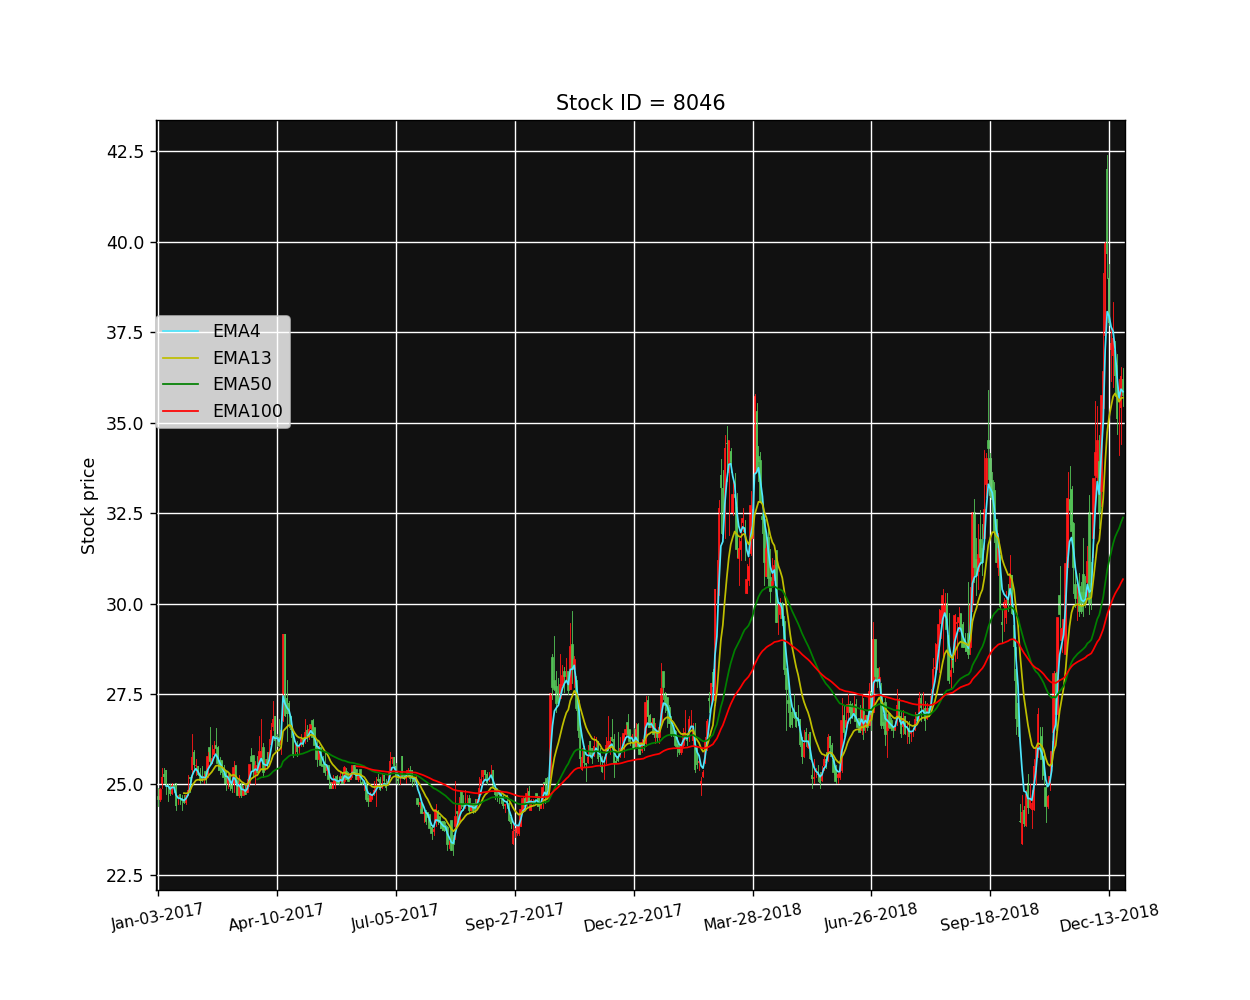

<IPython.core.display.Javascript object>


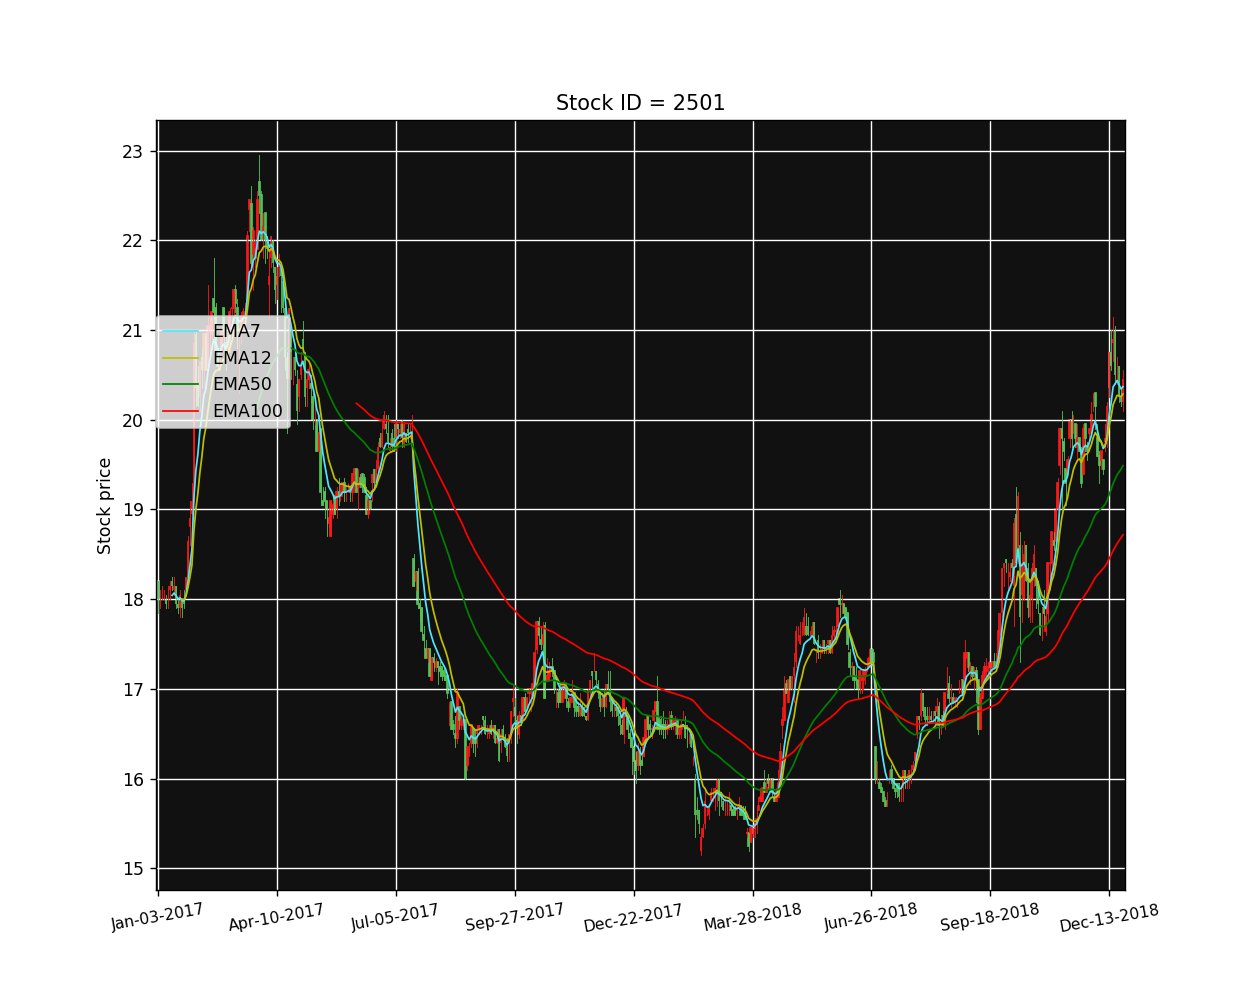

<IPython.core.display.Javascript object>


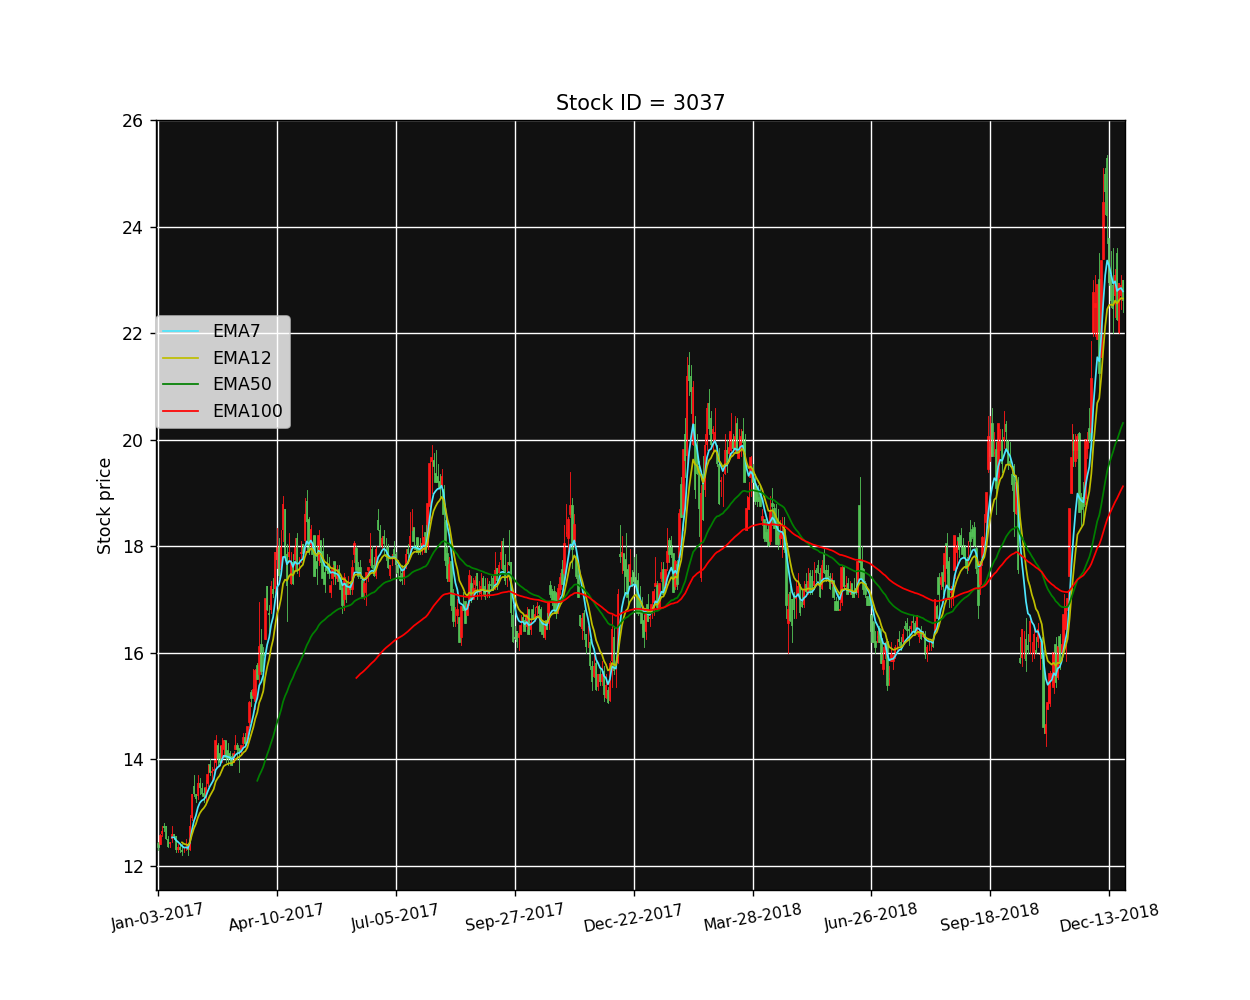

In [18]:
%matplotlib notebook
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
from matplotlib import ticker as mticker
from matplotlib.dates import DateFormatter, WeekdayLocator, DayLocator, MONDAY,YEARLY
from matplotlib.dates import MonthLocator,MONTHLY

def weekday_candlestick(ohlc_data, ax, fmt='%b-%d-%Y', freq=10, **kwargs):
# Wrapper function for matplotlib.finance.candlestick_ohlc that artificially spaces data to avoid gaps from weekends
    # Convert data to numpy array
    ohlc_data_arr = np.array(ohlc_data)[::-1]
    ohlc_data_arr2 = np.hstack([np.arange(ohlc_data_arr[:,0].size)[:,np.newaxis], ohlc_data_arr[:,1:]])
    ndays = ohlc_data_arr2[:,0]  # array([0, 1, 2, ... n-2, n-1, n])
    # Convert matplotlib date numbers to strings based on `fmt`
    dates = mdates.num2date(ohlc_data_arr[:,0])
    date_strings = []
    for date in dates:
        date_strings.append(date.strftime(fmt))
    # Plot candlestick chart
    candlestick_ohlc(ax, ohlc_data_arr2, **kwargs, colorup='#ff1717', colordown='#53c156')
    # Format x axis
    ax.set_xticks(ndays[::freq])
    ax.set_xticklabels(date_strings[::freq], rotation=10,fontsize=9)
    ax.set_xlim(ndays.min()-1, ndays.max()+1)
    plt.ylabel('Stock price')
    plt.show()

# Create figures and save them as JPEG files 
for i in range(len(res_list)):
    current_df = new_dataframe(backtest_df[i])
    fig = plt.figure(facecolor='w',figsize=(10,8))
    axes = fig.add_subplot(111,facecolor="#111111")
    axes.grid(True, color='w')
    weekday_candlestick(current_df, ax=axes, fmt='%b-%d-%Y', freq=60 ,width=0.3)
    # Set the plot titles
    axes.set_title("Stock ID = "+res_list[i])
    # add EMA5, EMA20, EMA50, EMA100
    av1 = np.array(current_df['收盤價'],dtype=float)[::-1]
    EMA_1 = roi_list[i][3]
    EMA_2 = roi_list[i][4]
    axes.plot(range(EMA_1,len(av1)),talib.EMA(av1,EMA_1)[-(len(av1)-EMA_1):],'#4ee6fd',label="EMA"+str(EMA_1), linewidth=1.0)
    axes.plot(range(EMA_2,len(av1)),talib.EMA(av1,EMA_2)[-(len(av1)-EMA_2):],'y',label="EMA"+str(EMA_2), linewidth=1.0)
    axes.plot(range(50,len(av1)),talib.EMA(av1,50)[-(len(av1)-50):],'g',label="EMA50", linewidth=1.0)
    axes.plot(range(100,len(av1)),talib.EMA(av1,100)[-(len(av1)-100):],'r',label="EMA100", linewidth=1.0)
    plt.legend(bbox_to_anchor=(0,0.6), loc=3, borderaxespad=0.)
    plt.savefig(res_list[i]+'.jpg')